# Imports

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import statsmodels.api as sm

from adjustText import adjust_text
from bs4 import BeautifulSoup
from pydeseq2.dds import DeseqDataSet
from IPython.display import display
from joblib import delayed, Parallel
from matplotlib import ticker
from matplotlib.colors import to_hex, TwoSlopeNorm
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
from matplotlib.patches import Patch
from pathlib import Path
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from statannotations.Annotator import Annotator
from tqdm.notebook import tqdm

# Setting general style of the plots

In [2]:
sns.set_theme(
    context="notebook",
    style="whitegrid",
    palette="muted",
    font="sans-serif",
    font_scale=1.25
)

# Constants

In [3]:
BP_TABLE = str.maketrans({"A": "T", "T": "A", "C": "G", "G": "C"})
HUMAN_CHROMOSOMES_NAMES = {str(i) for i in range(1, 23)} | {"X", "Y"}
CONSTRUCTS = ("PC-3#1", "PC-3#2", "PC-3#3")
CONSTRUCTS_DIRS = ("PC3_6", "PC3_7", "PC3_8")
CHROMOSOMES_DICT = None
MIR_NAME = "hsa-miR-93-5p"

# Dirs and file paths

## Dirs

In [4]:
PC3_MRNA_RESULTS_DIR = Path("/home/mega/our-data/14.11.2022_mRNA-seq/")
PC3_MIRNA_RESULTS_DIR = Path("/home/mega/our-data/14.03.2023_miRNA-seq/results")

BASE_DIR = Path("/home/mega/idkirillov")
FIGURES_DIR = BASE_DIR / "figures"
TCGA_FIGURES_DIR = FIGURES_DIR / "TCGA"

THREE_UTR_DIR = BASE_DIR / "three_prime_utr/"
FIVE_UTR_DIR = BASE_DIR / "five_prime_utr/"
CDS_DIR = BASE_DIR / "CDS/"
MIRDB_HTMLS_DIR = BASE_DIR / "mirdb_htmls/"
RNA22_DIR = BASE_DIR / "rna22_targets/"

## File paths

In [5]:
CHROMOSOMES_DICT_FILE = BASE_DIR / "chromosomes_dict.json"
PRIMARY_ASSEMBLY_FILE = Path("/huge/bulk/Ensembl_96/Homo_sapiens.GRCh38.dna.primary_assembly.fa")
MIRBASE_FILE = Path("/huge/bulk/miRBase/miRBase_22.1.tsv")

suffix = "gencode.v34.annotation_utr.gtf"
ALL_GENES_FILE = BASE_DIR / f"all_genes_{suffix}.txt"
ALL_CODING_GENES_FILE = BASE_DIR / f"all_genes_{suffix}.coding.txt"
ALL_TRANSCRIPTS_FILE = BASE_DIR / f"all_transcripts_{suffix}.txt"

THREE_PRIME_UTR_COORDINATES_FILE = THREE_UTR_DIR / f"three_prime_utr_transcript_coordinates_{suffix}.tsv"
FIVE_PRIME_UTR_COORDINATES_FILE = FIVE_UTR_DIR / f"five_prime_utr_transcript_coordinates_{suffix}.tsv"
CDS_COORDINATES_FILE = CDS_DIR / f"CDS_transcript_coordinates_{suffix}.tsv"

# Saving/Loading chromosome sequences

In [6]:
def get_chromosomes_dict(chromosomes_path: Path = CHROMOSOMES_DICT_FILE,
                         primary_assembly_path: Path = PRIMARY_ASSEMBLY_FILE):
    global CHROMOSOMES_DICT
    if CHROMOSOMES_DICT is None:
        if chromosomes_path.exists():
            with open(chromosomes_path) as fload:
                CHROMOSOMES_DICT = json.load(fload)
        else:
            with open(primary_assembly_path) as fread:
                CHROMOSOMES_DICT = {}
                buffer_list: list[str] = []
                chrom_num = ""
                for line in fread:
                    if line.startswith(">"):
                        CHROMOSOMES_DICT[chrom_num] = "".join(buffer_list)
                        buffer_list = []
                        chrom_num = line.split(maxsplit=1)[0].lstrip(">")
                    else:
                        buffer_list.append(line.rstrip())
            CHROMOSOMES_DICT.pop("")
            with open(chromosomes_path, "w") as fsave:
                json.dump(CHROMOSOMES_DICT, fsave)
    return CHROMOSOMES_DICT

In [7]:
CHROMOSOMES_DICT = get_chromosomes_dict()

# Small util functions

In [8]:
def get_reverse_complement_seq(seq: str):
    return seq[::-1].translate(BP_TABLE)


def get_isomir_name(isomir_num: int, mir_name: str = MIR_NAME):
    return f"{mir_name}|+{isomir_num}" if isomir_num > 0 else f"{mir_name}|{isomir_num}"

In [9]:
def df_index_from_symbol_to_id(df):
    reindex_dict = {
        s: (i.split(".")[0] + "_PAR_Y" if i.endswith("_PAR_Y") else i.split(".")[0])
        for s, i in gene_symbol_to_id.items()
    }
    return df.rename(index=reindex_dict)
    
    
def df_index_from_id_to_symbol(df):
    reindex_dict = {
        (i.split(".")[0] + "_PAR_Y" if i.endswith("_PAR_Y") else i.split(".")[0]): s
        for i, s in gene_id_to_symbol.items()
    }
    df.index = df.index.str.split(".", expand=True).get_level_values(0)
    return df.rename(index=reindex_dict)

# Loading isomiR seeds and gene/transcripts mapping dicts

In [10]:
def get_mir_isomirs_seed(names={MIR_NAME}, seed_len: int = 7, mirbase_path: Path = MIRBASE_FILE):
    canon_sequences = {}
    isomirs_seed = {}
    with open(mirbase_path) as fread:
        for line in fread:
            line_lst = line.rstrip().split()
            name = line_lst[2]
            if name in names:
                sequence = line_lst[8]
                start = int(line_lst[9])
                end = int(line_lst[10])
                sequence = sequence.replace("U", "T")
                mature_len = end - start + 1
                canon_sequences[name] = sequence
                isomirs_seed[name] = {
                    i-start: sequence[i : i+seed_len] 
                    for i in range(max(start - 5, 1), min(len(sequence) - mature_len + 1, start + 5) + 1)
                }
                if len(canon_sequences) == len(names):
                    break
    return isomirs_seed

In [11]:
isomirs_6seed = get_mir_isomirs_seed(seed_len=6)[MIR_NAME]
isomirs_7seed = get_mir_isomirs_seed(seed_len=7)[MIR_NAME]

In [12]:
def get_mapping_dicts(sequence_type: str = "gene",
                      genes_filename: Path = ALL_GENES_FILE,
                      coding_genes_filename: Path = ALL_CODING_GENES_FILE,
                      transcripts_filename: Path = ALL_TRANSCRIPTS_FILE):
    if sequence_type == "gene":
        filename = genes_filename
    elif sequence_type == "coding gene":
        filename = coding_genes_filename
    elif sequence_type == "transcript":
        filename = transcripts_filename
    else:
        raise ValueError("Use one of the following: 'gene', 'coding gene' or 'transcript'")

    with open(filename) as fread:
        id_to_symbol = {}
        symbol_to_id = {}
        for line in fread:
            symbol, idd = line.rstrip().split()
            id_to_symbol[idd] = symbol
            symbol_to_id[symbol] = idd
    return id_to_symbol, symbol_to_id

In [13]:
gene_id_to_symbol, gene_symbol_to_id = get_mapping_dicts("gene")

In [14]:
tr_id_to_symbol, tr_symbol_to_id = get_mapping_dicts("transcript")

# Loading genes/transcripts sequences of each region

## Modified Klee's algorithm to obtain gene region sequences as unions of corresponding transcripts regions

In [15]:
def coords_union(coords_list):
    coords_list.sort()
    open_count = 0
    start = None
    union = []
    for point in coords_list:
        if point[1]:
            open_count -= 1
            if not open_count:
                union.append((start, point[0]))
        else:
            if not open_count:
                start = point[0]
            open_count += 1
    return union


def get_genes_region_seq_from_union_dict(region_file: Path):
    seq_dict = {}
    prev_chrom_num = None
    prev_strand = None
    prev_gene_id = None
    coords_list = []
    
    gene_id_to_symbol, gene_symbol_to_id = get_mapping_dicts("gene")

    with open(region_file) as fread:
        for line in fread:
            chrom_num, start, end, strand, tr_id, gene_id = line.split()
            if chrom_num not in HUMAN_CHROMOSOMES_NAMES or gene_id not in gene_id_to_symbol:
                continue
            
            if prev_gene_id and gene_id != prev_gene_id:
                union = coords_union(coords_list)
                coords_list = []
                
                gene_symbol = gene_id_to_symbol[prev_gene_id]
                seq_dict[gene_symbol] = ""
                if prev_strand == "+":
                    for (left, right) in union:
                        chrom_seq = CHROMOSOMES_DICT[prev_chrom_num][int(left)-1 : int(right)]
                        seq_dict[gene_symbol] += chrom_seq
                else:
                    for (left, right) in reversed(union):
                        chrom_seq = CHROMOSOMES_DICT[prev_chrom_num][int(left)-1 : int(right)]
                        seq_dict[gene_symbol] += get_reverse_complement_seq(chrom_seq)
            
            coords_list.append((start, False))
            coords_list.append((end, True))
            
            prev_chrom_num = chrom_num
            prev_strand = strand
            prev_gene_id = gene_id
    return seq_dict

In [16]:
# three_prime_utrs = get_genes_region_seq_from_union_dict(THREE_PRIME_UTR_COORDINATES_FILE)
# five_prime_utrs = get_genes_region_seq_from_union_dict(FIVE_PRIME_UTR_COORDINATES_FILE)
# cdss = get_genes_region_seq_from_union_dict(CDS_COORDINATES_FILE)

# full_sequences = {}
# for name, seq in tqdm(cdss.items()):
#     full_sequences[name] = ""
#     if name in five_prime_utrs:
#         full_sequences[name] += five_prime_utrs[name]
#     full_sequences[name] += cdss[name]
#     if name in three_prime_utrs:
#         full_sequences[name] += three_prime_utrs[name]

## Simply reading transcript regions sequences

In [17]:
def get_transcripts_region_seq_dict(region_file: Path):
    seq_dict = {}
    tr_id_to_symbol, tr_symbol_to_id = get_mapping_dicts("transcript")
    
    with open(region_file) as fread:
        for line in fread:
            chrom_num, start, end, strand, tr_id, gene_id = line.split()
            if chrom_num not in HUMAN_CHROMOSOMES_NAMES or tr_id not in tr_id_to_symbol:
                continue

            tr_symbol = tr_id_to_symbol[tr_id]
            if tr_symbol not in seq_dict:
                seq_dict[tr_symbol] = ""

            chrom_seq = CHROMOSOMES_DICT[chrom_num][int(start)-1 : int(end)]
            if strand == "+":
                seq_dict[tr_symbol] += chrom_seq
            else:
                seq_dict[tr_symbol] += get_reverse_complement_seq(chrom_seq)
    return seq_dict

In [18]:
three_prime_utrs = get_transcripts_region_seq_dict(THREE_PRIME_UTR_COORDINATES_FILE)
five_prime_utrs = get_transcripts_region_seq_dict(FIVE_PRIME_UTR_COORDINATES_FILE)
cdss = get_transcripts_region_seq_dict(CDS_COORDINATES_FILE)

full_sequences = {}
for name, seq in tqdm(cdss.items()):
    full_sequences[name] = ""
    if name in five_prime_utrs:
        full_sequences[name] += five_prime_utrs[name]
    full_sequences[name] += cdss[name]
    if name in three_prime_utrs:
        full_sequences[name] += three_prime_utrs[name]

# Finding all reverse complement genes (targets) in 3'UTR/5'UTR/CDS/full seq regions (among human chromosomes) and loading miRDB/RNA22 targets

In [19]:
def get_reverse_complements_set(region_seq_dict, isomir_seq):
    reverse_compl_isomir_seq = get_reverse_complement_seq(isomir_seq)
    reverse_complements = set()
    for name, seq in region_seq_dict.items():
        if seq.find(reverse_compl_isomir_seq) != -1:
            reverse_complements.add(name)
    return reverse_complements


def read_targets_file(targets_filename, id_to_sym=gene_id_to_symbol):
    targets = set()
    with open(targets_filename) as fread:
        for line in fread:
            id = line.rstrip()
            if id in id_to_sym:
                targets.add(id_to_sym[line.rstrip()])
    return targets


def read_mirdb_targets(html_filenames_dir=MIRDB_HTMLS_DIR, min_score=80):
    mirdb_targets = {}
    
    for filename in html_filenames_dir.iterdir():
        isomir_num = int(filename.stem)
        with open(filename) as fread:
            html_page = BeautifulSoup(fread)
            scores = []
            names = []
            for i, line in enumerate(html_page.body.find_all("input")):
                if i % 9 == 1:
                    score = int(line["value"])
                    if score < min_score:
                        break
                    scores.append(score)
                if i % 9 == 4:
                    names.append(line["value"])

            mirdb_targets[isomir_num] = set(names)
    return mirdb_targets

In [20]:
mirdb_targets = read_mirdb_targets()

In [21]:
def transcripts_to_genes(target_set):
    return {target.split("-")[0] for target in target_set}

In [22]:
reverse_complements_3utr = {}
reverse_complements = {}

reverse_complements_3utr_6mer = {}
reverse_complements_6mer = {}

rna22_targets = {}

table_rows = []

for (isomir_num, isomir_seed_seq) in tqdm(isomirs_7seed.items()):
    reverse_complements_3utr[isomir_seed_seq] = get_reverse_complements_set(
        three_prime_utrs, isomir_seed_seq
    )
    reverse_complements[isomir_seed_seq] = get_reverse_complements_set(
        full_sequences, isomir_seed_seq
    )
    
    isomir_seed_seq_6mer = isomirs_6seed[isomir_num]
    reverse_complements_3utr_6mer[isomir_seed_seq_6mer] = get_reverse_complements_set(
        three_prime_utrs, isomir_seed_seq_6mer
    )
    reverse_complements_6mer[isomir_seed_seq_6mer] = get_reverse_complements_set(
        full_sequences, isomir_seed_seq_6mer
    )
    
    # From transcripts to genes
    reverse_complements_3utr[isomir_seed_seq] = transcripts_to_genes(
        reverse_complements_3utr[isomir_seed_seq]
    )
    reverse_complements[isomir_seed_seq] = transcripts_to_genes(
        reverse_complements[isomir_seed_seq]
    )
    
    reverse_complements_3utr_6mer[isomir_seed_seq_6mer] = transcripts_to_genes(
        reverse_complements_3utr_6mer[isomir_seed_seq_6mer]
    )
    reverse_complements_6mer[isomir_seed_seq_6mer] = transcripts_to_genes(
        reverse_complements_6mer[isomir_seed_seq_6mer]
    )
    
    if 0 <= isomir_num <= 5:
        rna22_targets[isomir_num] = read_targets_file(
            RNA22_DIR / f"hsa_miR_93_5p_{isomir_num}_target_genes.txt"
        )
    
    table_rows.append({
        "isomiR": get_isomir_name(isomir_num),
        "seed seq": isomir_seed_seq, 
        "3'UTR (7mer)": len(reverse_complements_3utr[isomir_seed_seq]), 
        "full seq (7mer)": len(reverse_complements[isomir_seed_seq]),
        "3'UTR (6mer)": len(reverse_complements_3utr_6mer[isomir_seed_seq_6mer]), 
        "full seq (6mer)": len(reverse_complements_6mer[isomir_seed_seq_6mer]),
        "mirdb>=80": len(mirdb_targets[isomir_num]),
        "rna22": len(rna22_targets[isomir_num]) if 0 <= isomir_num <= 5 else 0
    })

# Target counts by region + miRDB/RNA22

In [23]:
pd.DataFrame(table_rows)

,isomiR,seed seq,3'UTR (7mer),full seq (7mer),3'UTR (6mer),full seq (6mer),mirdb>=80,rna22
0,hsa-miR-93-5p|-5,GCTCCAA,2741,5361,8692,15076,77,0
1,hsa-miR-93-5p|-4,CTCCAAA,4588,7399,9115,13878,249,0
2,hsa-miR-93-5p|-3,TCCAAAG,4437,7143,10138,13609,333,0
3,hsa-miR-93-5p|-2,CCAAAGT,5260,7260,10228,14319,211,0
4,hsa-miR-93-5p|-1,CAAAGTG,5316,7140,10116,13513,215,0
5,hsa-miR-93-5p|0,AAAGTGC,5026,6499,9968,12711,631,1577
6,hsa-miR-93-5p|+1,AAGTGCT,5177,7061,8163,11343,338,2104
7,hsa-miR-93-5p|+2,AGTGCTG,5077,7747,8745,12470,107,3834
8,hsa-miR-93-5p|+3,GTGCTGT,2875,5352,9172,14310,104,7096
9,hsa-miR-93-5p|+4,TGCTGTT,3986,7298,9131,14410,132,8831


# Loading PC-3 mRNA-seq data

In [24]:
mrna_counts = {}
mrna_log_expressions = {}
mrna_results = {}

mrna_total_results = None

for c, cdir in zip(CONSTRUCTS, CONSTRUCTS_DIRS):
    cpath = PC3_MRNA_RESULTS_DIR / cdir 
    mrna_counts[c] = pd.read_table(cpath / "STAR_counts.tsv", index_col=0)
    
    mrna_log_expressions[c] = pd.read_table(cpath / "STAR_log2_FPKM_DESeq2.tsv", index_col=0)
    
    mrna_results[c] = pd.read_table(cpath / "STAR_overexp_vs_control_all.tsv", index_col=-1)
    if mrna_total_results is None:
        mrna_total_results = pd.DataFrame(index=mrna_results[c].index)
    mrna_total_results[c] = mrna_results[c].log2FoldChange

mrna_total_counts = pd.read_table(PC3_MRNA_RESULTS_DIR / "PC3" / "STAR_counts.tsv", index_col=0)
mrna_total_log_expressions = pd.read_table(PC3_MRNA_RESULTS_DIR / "PC3" / "STAR_log2_FPKM_DESeq2.tsv", 
                                           index_col=0)

mrna_total_annotation = pd.read_table(PC3_MRNA_RESULTS_DIR / "PC3" / "annotation.tsv", index_col=0)
mrna_total_annotation = mrna_total_annotation.replace(
    dict(zip(mrna_total_annotation.Group.unique(), [*CONSTRUCTS, "Control"]))
)

## Quality control

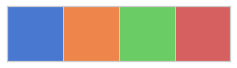

In [25]:
GROUP_COLORS = sns.color_palette("muted", as_cmap=True)[:4]
sns.palplot(GROUP_COLORS)

In [26]:
if "mrna_dds" not in globals():
    mrna_dds = DeseqDataSet(counts=mrna_total_counts.T, 
                            clinical=mrna_total_annotation, 
                            design_factors=mrna_total_annotation.columns[0])
    mrna_dds.vst()

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 22.92 seconds.

Fitting dispersion trend curve...
... done in 32.77 seconds.



In [27]:
def plot_samples_pca(counts_df, counts_annotation,
                     vst_counts=None, colors=None, top=300):
    if vst_counts is not None:
        deseq2_normalized = pd.DataFrame(data=vst_counts, 
                                         index=counts_annotation.index,
                                         columns=counts_df.index)
    else:
        n_samples = counts_df.shape[1]
        log_counts = np.log2(counts_df)
        geom_mean = log_counts.mean(axis=1)
        geom_mean = geom_mean[np.abs(geom_mean) != np.inf]
        log_counts = log_counts.loc[geom_mean.index].sub(geom_mean, axis=0)
        normalization_factors = 2 ** log_counts.median()
        deseq2_normalized = (counts_df / normalization_factors).T
        deseq2_normalized = np.log2(deseq2_normalized + 1)

    if top:
        selected_idx = deseq2_normalized.var().sort_values(ascending=False)[:top].index
        deseq2_normalized = deseq2_normalized[selected_idx]

    pca = PCA(2)
    pc1, pc2 = pca.fit_transform(deseq2_normalized).T
    
    if colors is None:
        color_list = ["#7cae00", "#00bfc4", "#c77cff", "#f8766d"]
    else:
        color_list = colors
    groups = counts_annotation.Group.unique()
    cdict = dict(zip(groups, color_list))
    
    fig, ax = plt.subplots(figsize=(5, 10))
    for g in groups:
        mask = counts_annotation.Group == g
        ax.scatter(pc1[mask], pc2[mask], c=cdict[g], label=g, s=100)

    texts = []
    for i, txt in enumerate(deseq2_normalized.index):
        text = plt.text(x=pc1[i], y=pc2[i], s=txt, fontsize=10)
        texts.append(text)
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color="black", lw=0.5))
    plt.xlabel(f"PC 1 ({100*pca.explained_variance_ratio_[0]:.3f}%)")
    plt.ylabel(f"PC 2 ({100*pca.explained_variance_ratio_[1]:.3f}%)")
    
    return fig

In [28]:
def dist_mat_clustering(counts_df, counts_annotation, 
                        vst_counts=None, colors=None, cbar_pos=(0.02, 0.8, 0.05, 0.18)):
    if vst_counts is not None:
        deseq2_normalized = pd.DataFrame(data=vst_counts, 
                                         index=counts_annotation.index,
                                         columns=counts_df.index)
    else:
        n_samples = counts_df.shape[1]
        log_counts = np.log2(counts_df)
        geom_mean = log_counts.mean(axis=1)
        geom_mean = geom_mean[np.abs(geom_mean) != np.inf]
        log_counts = log_counts.loc[geom_mean.index].sub(geom_mean, axis=0)
        normalization_factors = 2 ** log_counts.median()
        deseq2_normalized = (counts_df / normalization_factors).T
        deseq2_normalized = np.log2(deseq2_normalized + 1)

    distmat = pd.DataFrame(distance_matrix(deseq2_normalized, deseq2_normalized), 
                           index=counts_df.columns, columns=counts_df.columns)
    
    if colors is None:
        color_list = ["#7cae00", "#00bfc4", "#c77cff", "#f8766d"]
    else:
        color_list = colors
    groups = counts_annotation.Group.unique()
    cdict = dict(zip(groups, color_list))
    colors = counts_annotation.replace(cdict)

    g = sns.clustermap(distmat, method="ward",
                       col_colors=colors,
                       cmap=sns.color_palette("rocket", as_cmap=True),
                       cbar_pos=cbar_pos)
    g.ax_row_dendrogram.set_visible(None)
    
    handles = [Patch(facecolor=cdict[name]) for name in ["Control", *CONSTRUCTS]]
    plt.legend(handles, ["Control", *CONSTRUCTS], title=None,
               bbox_to_anchor=(0.96, 0.97), bbox_transform=plt.gcf().transFigure, loc="upper right")
    
    return g

In [29]:
def pca_explorer_analysis(counts_df, counts_annotation, 
                          dds=None, clist=None, save=True, name="seq", cbar_pos=(0.02, 0.8, 0.05, 0.18)):
    sns.set_theme(context="notebook", style="whitegrid", palette="muted", font="sans-serif", font_scale=1.25)

    if dds is None:
        dds = DeseqDataSet(counts=counts_df.T, clinical=counts_annotation, 
                           design_factors=counts_annotation.columns[0])
        dds.vst()
    vst_counts = dds.layers["vst_counts"]
    
    g = dist_mat_clustering(counts_df, counts_annotation, vst_counts, colors=clist, cbar_pos=cbar_pos)
    fig = plot_samples_pca(counts_df, counts_annotation, vst_counts, colors=clist)

    if save:
        g.savefig(FIGURES_DIR / Path(f"{name}_samples_clustermap.png"), dpi=350)
        g.savefig(FIGURES_DIR / Path(f"{name}_samples_clustermap.tiff"), dpi=1200)
        
        fig.tight_layout()
        fig.savefig(FIGURES_DIR / Path(f"{name}_samples_pca.png"), dpi=350)
        fig.savefig(FIGURES_DIR / Path(f"{name}_samples_pca.tiff"), dpi=1200)

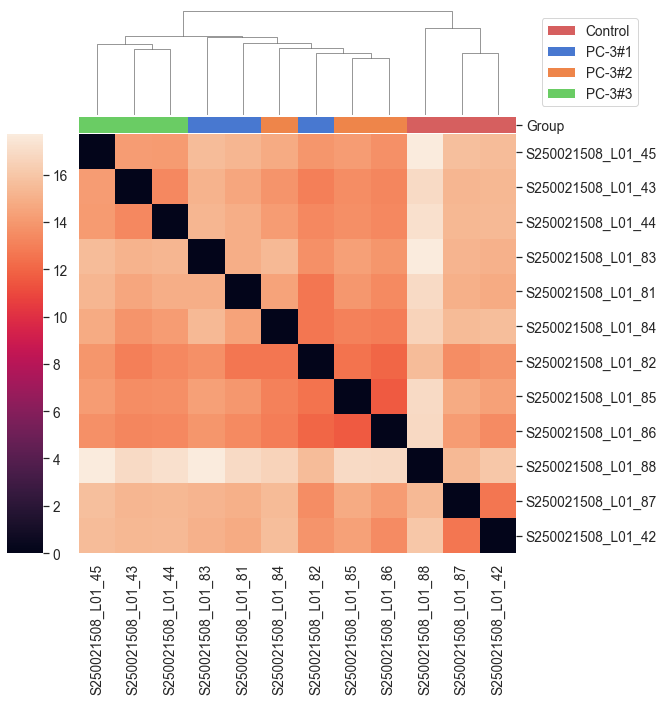

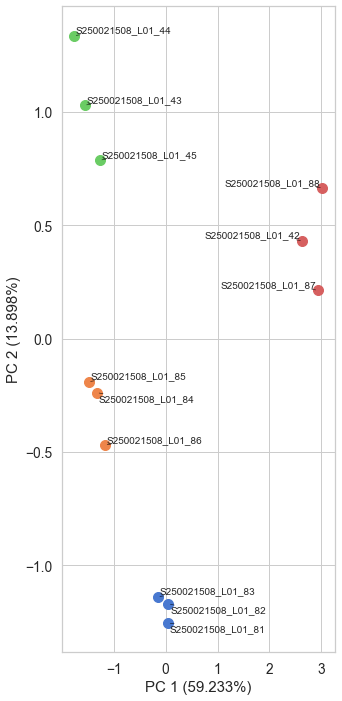

In [30]:
pca_explorer_analysis(
    mrna_total_counts, mrna_total_annotation,
    dds=mrna_dds, clist=GROUP_COLORS, save=True, name="mRNA", cbar_pos=(0.075, 0.218, 0.05, 0.582)
)

# Cleaning out enclosing gene pools for each construct

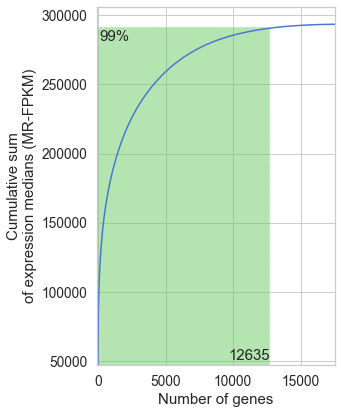

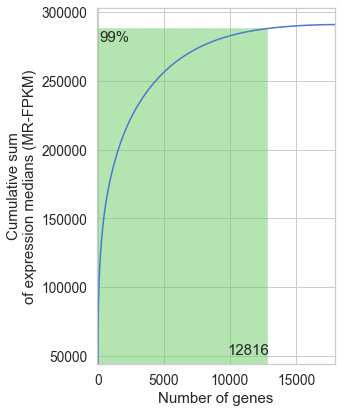

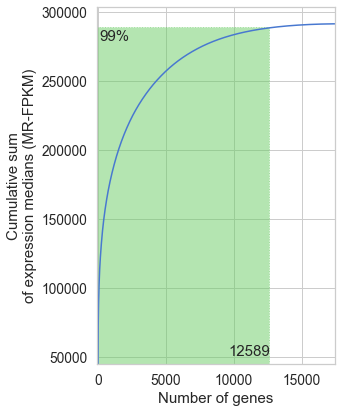

In [31]:
THRESH = 0.99

all_significant_genes = {}
all_genes = set(gene_symbol_to_id.keys())


for i, c in enumerate(CONSTRUCTS):
    expressions = 2**mrna_log_expressions[c] - 1
    zero_expression_filtered = expressions[expressions.min(axis=1) > 0]
    expressions_medians = zero_expression_filtered.median(axis=1).sort_values(ascending=False)
    explained_level = THRESH * expressions_medians.sum()
    explained_mask = expressions_medians.cumsum() <= explained_level
    selected = set(expressions_medians[explained_mask].index)
    all_significant_genes[c] = all_genes & selected
    
    fig = plt.figure(figsize=(5, 6))
    ax = plt.subplot(111)
    sns.lineplot(expressions_medians.cumsum().values, ax=ax)
    ax.set_xlim(xmin=-100, xmax=len(expressions_medians))
    ax.set_ylim(expressions_medians[0])
    x_bound = len(all_significant_genes[c])
    y_bound = explained_level
    ax.axvspan(-100, x_bound, ymax=y_bound/ax.get_ylim()[1] - 0.006, 
               alpha=0.5, color="#6ACC64", linestyle="dotted")
    ax.annotate(text=f"{x_bound}", xy=(x_bound - 3000, 51000))
    ax.annotate(text=f"{int(THRESH * 100)}%", xy=(100, y_bound - 9000))
    ax.set_xlabel("Number of genes")
    ax.set_ylabel("Cumulative sum\nof expression medians (MR-FPKM)")

    plt.tight_layout()

    fig.savefig(FIGURES_DIR / Path(f"{c}_gene_cutoff.png"), dpi=350)
    fig.savefig(FIGURES_DIR / Path(f"{c}_gene_cutoff.tiff"), dpi=1200)

# Extracting genes by their log2FoldChange

In [32]:
DOWNREGULATED_CUTOFF = -1

downregulated_genes = {}
not_downregulated_genes = {}
strongly_downregulated_genes = {}

for c in CONSTRUCTS:
    significant_mask = mrna_results[c]["padj"] < 0.05
    downregulated_mask = mrna_results[c]["log2FoldChange"] < 0
    cutoff_downregulated_mask = mrna_results[c]["log2FoldChange"] < DOWNREGULATED_CUTOFF
    
    downregulated_genes[c] = set(mrna_results[c][significant_mask & downregulated_mask].index)
    not_downregulated_genes[c] = set(mrna_results[c][~(significant_mask & downregulated_mask)].index)
    strongly_downregulated_genes[c] = set(mrna_results[c][significant_mask & cutoff_downregulated_mask].index)

# Investigating downregulated genes overlap across constructs

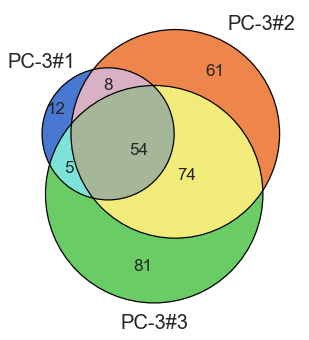

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

out = venn3([downregulated_genes[c] & all_significant_genes[c] for c in CONSTRUCTS], 
            set_labels=[c for c in CONSTRUCTS], 
            set_colors=GROUP_COLORS[:-1], alpha=1,
            ax=ax)
for text in out.subset_labels:
    if text:
        text.set_fontsize(17)
for text in out.set_labels:
    if text:
        text.set_fontsize(20)
venn3_circles([downregulated_genes[c] & all_significant_genes[c] for c in CONSTRUCTS],
              color="black", linestyle="solid", linewidth=1.25, ax=ax)

plt.tight_layout()

plt.savefig(FIGURES_DIR / Path("downregulated_genes_venn.png"), dpi=350)
plt.savefig(FIGURES_DIR / Path("downregulated_genes_venn.tiff"), dpi=1200)

In [34]:
color_annotation = mrna_total_annotation.replace(dict(zip(mrna_total_annotation.Group.unique(), GROUP_COLORS)))

In [35]:
union = set()
genes_to_constructs = pd.DataFrame(index=list(all_genes))
for c, col in zip(CONSTRUCTS, GROUP_COLORS):
    downregulated = downregulated_genes[c] & all_significant_genes[c]
    indexes = genes_to_constructs.index.intersection(downregulated)
    genes_to_constructs.loc[indexes, c] = True
    union |= downregulated

genes_to_constructs = (
    genes_to_constructs
    .dropna(how="all")
    .fillna(False)
    .astype(int)
    .astype(str)
    .sum(axis=1)
    .to_frame("Venn")
)
genes_to_constructs["Color"] = genes_to_constructs.Venn.apply(
    lambda id: to_hex(out.get_patch_by_id(id).get_facecolor())
)

In [36]:
venn_codes = ["001", "010", "100", "011", "101", "110", "111"]
venn_to_color = dict(zip(genes_to_constructs["Venn"], genes_to_constructs["Color"]))
permutations_n = 10**6

In [37]:
def pval_to_combined_star(p):
    if p > 0.05:
        return f"ns ({p=:.2f})"
    elif p > 0.01:
        return f"* ({p=:.3f})"
    elif p > 0.001:
        return f"** ({p=:.4f})"
    elif p > 0.0001:
        return f"*** ({p=:.2e})"
    else:
        return f"**** ({p=:.2e})"

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

110 vs. 111: ns (p=0.69)
101 vs. 111: ns (p=0.69)
011 vs. 111: ns (p=0.55)
100 vs. 111: ns (p=0.69)
010 vs. 111: * (p=0.025)
001 vs. 111: * (p=0.017)


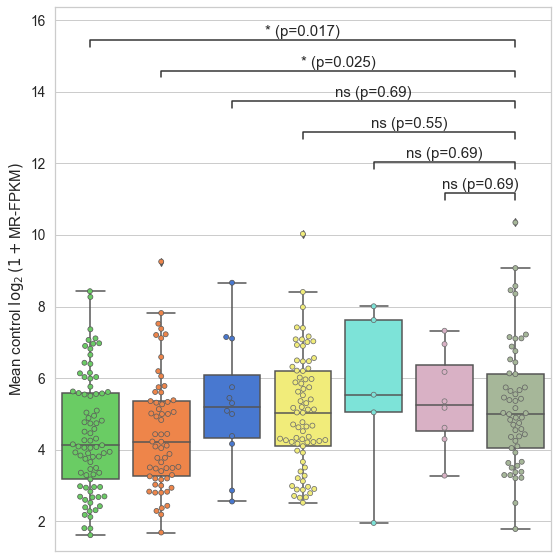

In [38]:
plt.figure(figsize=(8, 8))
df = genes_to_constructs.copy()
df["Mean_ctrl_log_expr"] = mrna_total_log_expressions.loc[df.index].iloc[:, -3:].mean(axis=1)


pval_df = pd.DataFrame(index=venn_codes[:-1])
pval_df["P-value"] = df.groupby("Venn").apply(
    lambda g: sps.ttest_ind(
        g["Mean_ctrl_log_expr"], df.loc[df["Venn"] == "111", "Mean_ctrl_log_expr"],
        alternative="less", permutations=permutations_n
    ).pvalue
)
pval_df["Adjusted p-value"] = sm.stats.multipletests(pval_df["P-value"], method="fdr_bh")[1]
formatted_pvalues = [pval_to_combined_star(p) for p in pval_df["Adjusted p-value"]]


plotting_parameters = {
    "data": df,
    "x": "Venn",
    "y": "Mean_ctrl_log_expr",
    "order": venn_codes,
    "palette": venn_to_color
}
ax = sns.boxplot(**plotting_parameters, saturation=1)
ax = sns.swarmplot(**plotting_parameters, linewidth=0.75, ax=ax)
ax.set_xticklabels([])
ax.set_xlabel(None)
ax.set_ylabel("Mean control $\log_2(1+$MR-FPKM$)$")


annotator = Annotator(
    ax=ax, 
    pairs=[(code, "111") for code in venn_codes[:-1]], 
    **plotting_parameters
)
annotator.configure(
    loc="inside"
)
annotator.set_custom_annotations(formatted_pvalues)
annotator.annotate()


plt.tight_layout()

plt.savefig(FIGURES_DIR / Path("overlap_vs_each_ctrl_expr.png"), dpi=350)
plt.savefig(FIGURES_DIR / Path("overlap_vs_each_ctrl_expr.tiff"), dpi=1200)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

110 vs. 111: ns (p=0.09)
101 vs. 111: ns (p=0.69)
011 vs. 111: **** (p=1.40e-05)
100 vs. 111: *** (p=7.24e-04)
010 vs. 111: **** (p=3.00e-06)
001 vs. 111: **** (p=3.00e-06)


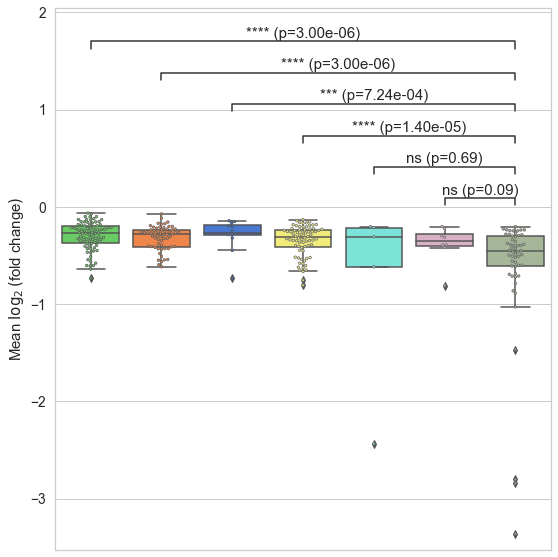

In [39]:
plt.figure(figsize=(8, 8))
df = genes_to_constructs.copy()
df["Mean_l2fc"] = mrna_total_results.loc[df.index].mean(axis=1)


pval_df = pd.DataFrame(index=venn_codes[:-1])
pval_df["P-value"] = df.groupby("Venn").apply(
    lambda g: sps.ttest_ind(
        g["Mean_l2fc"], df.loc[df["Venn"] == "111", "Mean_l2fc"],
        alternative="greater", permutations=permutations_n
    ).pvalue
)
pval_df["Adjusted p-value"] = sm.stats.multipletests(pval_df["P-value"], method="fdr_bh")[1]
formatted_pvalues = [pval_to_combined_star(p) for p in pval_df["Adjusted p-value"]]


plotting_parameters = {
    "data": df,
    "x": "Venn",
    "y": "Mean_l2fc",
    "order": venn_codes,
    "palette": venn_to_color
}
ax = sns.boxplot(**plotting_parameters, saturation=1)
ax = sns.swarmplot(**plotting_parameters, size=2.5, linewidth=0.75, ax=ax)
ax.set_xticklabels([])
ax.set_xlabel(None)
ax.set_ylabel("Mean $\log_2($fold change$)$")


annotator = Annotator(
    ax=ax, 
    pairs=[(code, "111") for code in venn_codes[:-1]], 
    **plotting_parameters
)
annotator.configure(
    loc="inside"
)
annotator.set_custom_annotations(formatted_pvalues)
annotator.annotate()


plt.tight_layout()

plt.savefig(FIGURES_DIR / Path("overlap_vs_each_l2fc.png"), dpi=350)
plt.savefig(FIGURES_DIR / Path("overlap_vs_each_l2fc.tiff"), dpi=1200)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Rest vs. Intersection: * (p=0.022)


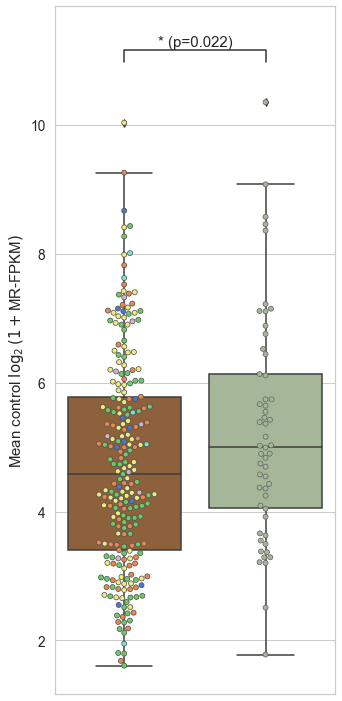

In [40]:
plt.figure(figsize=(5, 10))
df = genes_to_constructs.copy()
df.loc[df["Venn"] == "111", "Venn"] = "Intersection"
df.loc[df["Venn"] != "Intersection", "Venn"] = "Rest"
df["Mean_ctrl_log_expr"] = mrna_total_log_expressions.loc[df.index].iloc[:, -3:].mean(axis=1)


plotting_parameters = {
    "data": df,
    "x": "Venn",
    "y": "Mean_ctrl_log_expr",
    "order": ["Rest", "Intersection"]
}
ax = sns.boxplot(**plotting_parameters, palette={"Intersection": "#a6b799", "Rest": "#8c613c"}, saturation=1)
ax = sns.swarmplot(
    **plotting_parameters, hue="Color", palette={c: c for c in df["Color"]}, linewidth=0.75, ax=ax
)
ax.get_legend().remove()
ax.set_xticklabels([])
ax.set_xlabel(None)
ax.set_ylabel("Mean control $\log_2(1+$MR-FPKM$)$")


annotator = Annotator(
    ax=ax, 
    pairs=[("Rest", "Intersection")], 
    **plotting_parameters
)
annotator.configure(
    loc="inside"
)
pval = sps.ttest_ind(
    df.loc[df["Venn"] == "Rest", "Mean_ctrl_log_expr"],
    df.loc[df["Venn"] == "Intersection", "Mean_ctrl_log_expr"],
    alternative="less", permutations=permutations_n
).pvalue
annotator.set_custom_annotations([f"{pval_to_combined_star(pval)}"])
annotator.annotate()


plt.tight_layout()

plt.savefig(FIGURES_DIR / Path("overlap_vs_rest_ctrl_expr.png"), dpi=350)
plt.savefig(FIGURES_DIR / Path("overlap_vs_rest_ctrl_expr.tiff"), dpi=1200)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Rest vs. Intersection: **** (p=1.00e-06)


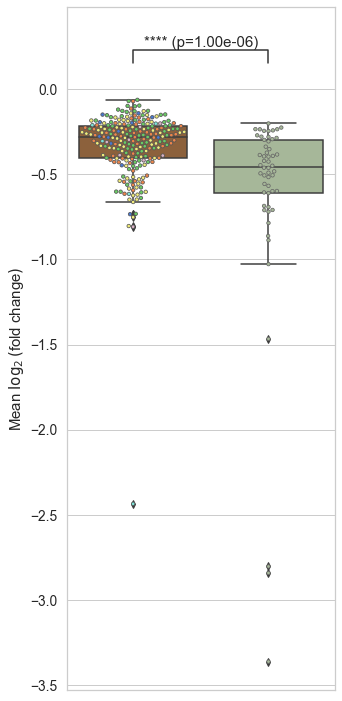

In [41]:
plt.figure(figsize=(5, 10))
df = genes_to_constructs.copy()
df.loc[df["Venn"] == "111", "Venn"] = "Intersection"
df.loc[df["Venn"] != "Intersection", "Venn"] = "Rest"
df["Mean_l2fc"] = mrna_total_results.loc[df.index].mean(axis=1)


plotting_parameters = {
    "data": df,
    "x": "Venn",
    "y": "Mean_l2fc",
    "order": ["Rest", "Intersection"]
}
ax = sns.boxplot(**plotting_parameters, palette={"Intersection": "#a6b799", "Rest": "#8c613c"}, saturation=1)
ax = sns.swarmplot(
    **plotting_parameters, hue="Color", size=3.5, palette={c: c for c in df["Color"]}, linewidth=0.75, ax=ax
)
ax.get_legend().remove()
ax.set_xticklabels([])
ax.set_xlabel(None)
ax.set_ylabel("Mean $\log_2($fold change$)$")


annotator = Annotator(
    ax=ax, 
    pairs=[("Rest", "Intersection")], 
    **plotting_parameters
)
annotator.configure(
    loc="inside"
)
pval = sps.ttest_ind(
    df.loc[df["Venn"] == "Rest", "Mean_l2fc"],
    df.loc[df["Venn"] == "Intersection", "Mean_l2fc"],
    alternative="greater", permutations=permutations_n
).pvalue
annotator.set_custom_annotations([f"{pval_to_combined_star(pval)}"])
annotator.annotate()


plt.tight_layout()

plt.savefig(FIGURES_DIR / Path("overlap_vs_rest_l2fc.png"), dpi=350)
plt.savefig(FIGURES_DIR / Path("overlap_vs_rest_l2fc.tiff"), dpi=1200)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Symdiff vs. Intersection: ** (p=0.0032)


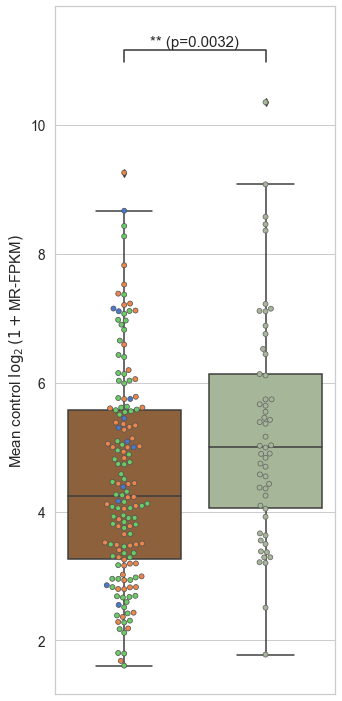

In [42]:
plt.figure(figsize=(5, 10))
df = genes_to_constructs[genes_to_constructs["Venn"].isin(("001", "010", "100", "111"))].copy()
df.loc[df["Venn"] == "111", "Venn"] = "Intersection"
df.loc[df["Venn"] != "Intersection", "Venn"] = "Symdiff"
df["Mean_ctrl_log_expr"] = mrna_total_log_expressions.loc[df.index].iloc[:, -3:].mean(axis=1)


plotting_parameters = {
    "data": df,
    "x": "Venn",
    "y": "Mean_ctrl_log_expr",
    "order": ["Symdiff", "Intersection"]
}
ax = sns.boxplot(**plotting_parameters, palette={"Intersection": "#a6b799", "Symdiff": "#8c613c"}, saturation=1)
ax = sns.swarmplot(
    **plotting_parameters, hue="Color", palette={c: c for c in df["Color"]}, linewidth=0.75, ax=ax
)
ax.get_legend().remove()
ax.set_xticklabels([])
ax.set_xlabel(None)
ax.set_ylabel("Mean control $\log_2(1+$MR-FPKM$)$")


annotator = Annotator(
    ax=ax, 
    pairs=[("Symdiff", "Intersection")], 
    **plotting_parameters
)
annotator.configure(
    loc="inside"
)
pval = sps.ttest_ind(
    df.loc[df["Venn"] == "Symdiff", "Mean_ctrl_log_expr"],
    df.loc[df["Venn"] == "Intersection", "Mean_ctrl_log_expr"],
    alternative="less", permutations=permutations_n
).pvalue
annotator.set_custom_annotations([f"{pval_to_combined_star(pval)}"])
annotator.annotate()


plt.tight_layout()

plt.savefig(FIGURES_DIR / Path("overlap_vs_symdiff_ctrl_expr.png"), dpi=350)
plt.savefig(FIGURES_DIR / Path("overlap_vs_symdiff_ctrl_expr.tiff"), dpi=1200)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Symdiff vs. Intersection: **** (p=1.00e-06)


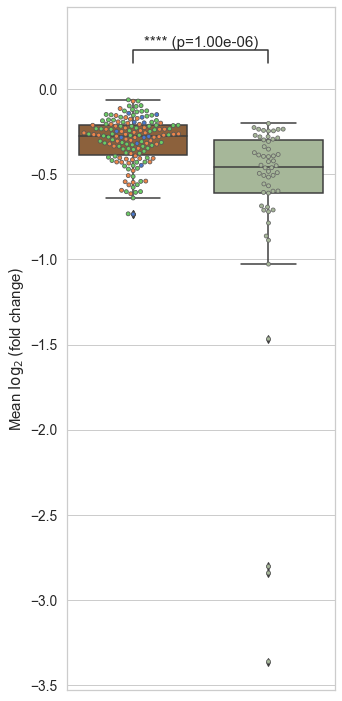

In [43]:
plt.figure(figsize=(5, 10))
df = genes_to_constructs[genes_to_constructs["Venn"].isin(("001", "010", "100", "111"))].copy()
df.loc[df["Venn"] == "111", "Venn"] = "Intersection"
df.loc[df["Venn"] != "Intersection", "Venn"] = "Symdiff"
df["Mean_l2fc"] = mrna_total_results.loc[df.index].mean(axis=1)


plotting_parameters = {
    "data": df,
    "x": "Venn",
    "y": "Mean_l2fc",
    "order": ["Symdiff", "Intersection"]
}
ax = sns.boxplot(**plotting_parameters, palette={"Intersection": "#a6b799", "Symdiff": "#8c613c"}, saturation=1)
ax = sns.swarmplot(
    **plotting_parameters, hue="Color", size=4, palette={c: c for c in df["Color"]}, linewidth=0.75, ax=ax
)
ax.get_legend().remove()
ax.set_xticklabels([])
ax.set_xlabel(None)
ax.set_ylabel("Mean $\log_2($fold change$)$")


annotator = Annotator(
    ax=ax, 
    pairs=[("Symdiff", "Intersection")], 
    **plotting_parameters
)
annotator.configure(
    loc="inside"
)
pval = sps.ttest_ind(
    df.loc[df["Venn"] == "Intersection", "Mean_l2fc"],
    df.loc[df["Venn"] == "Symdiff", "Mean_l2fc"],
    alternative="less", permutations=permutations_n
).pvalue
annotator.set_custom_annotations([f"{pval_to_combined_star(pval)}"])
annotator.annotate()


plt.tight_layout()

plt.savefig(FIGURES_DIR / Path("overlap_vs_symdiff_l2fc.png"), dpi=350)
plt.savefig(FIGURES_DIR / Path("overlap_vs_symdiff_l2fc.tiff"), dpi=1200)

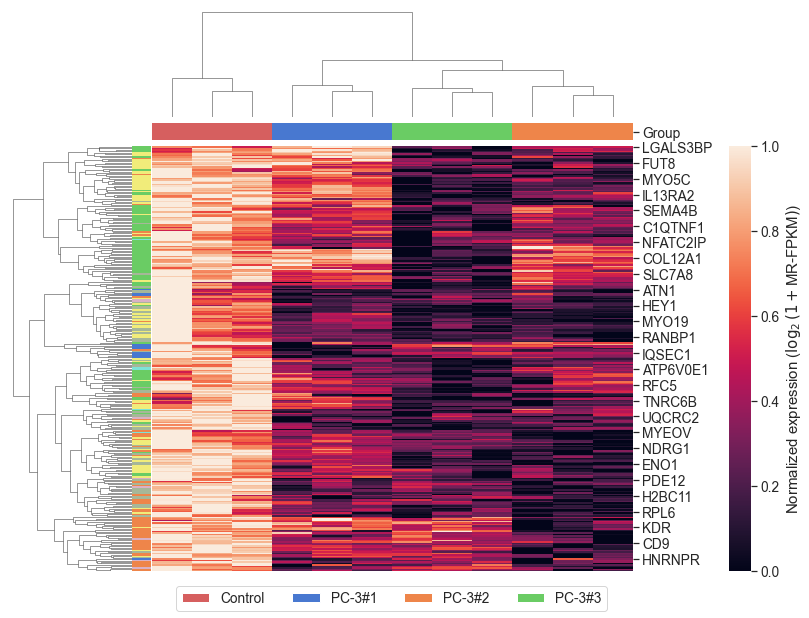

In [44]:
g = sns.clustermap(mrna_total_log_expressions.loc[list(union)],
                    method="complete",
                    standard_scale=0,
                    row_colors=genes_to_constructs["Color"],
                    col_colors=color_annotation,
                    cbar_pos=(1, .213, .03, .576),
                    cmap="rocket", figsize=(10.2475, 10.2475),
                    cbar_kws={"label": "Normalized expression ($\log_2(1+$MR-FPKM$)$)"})

g.ax_heatmap.set_xticklabels([])
handles = [Patch(facecolor=color) for color in 
           color_annotation.reindex(np.roll(color_annotation.index, shift=3)).Group.unique()]
g.ax_heatmap.legend(handles, 
                    mrna_total_annotation.reindex(np.roll(color_annotation.index, shift=3)).Group.unique(),
                    title=None,
                    bbox_to_anchor=(0.543, 0.15),
                    bbox_transform=plt.gcf().transFigure,
                    loc='lower center', ncols=4)
g.ax_row_colors.set_xticklabels("")

g.savefig(FIGURES_DIR / Path("venn_clustermap_legend.png"), dpi=350)
g.savefig(FIGURES_DIR / Path("venn_clustermap_legend.tiff"), dpi=1200)

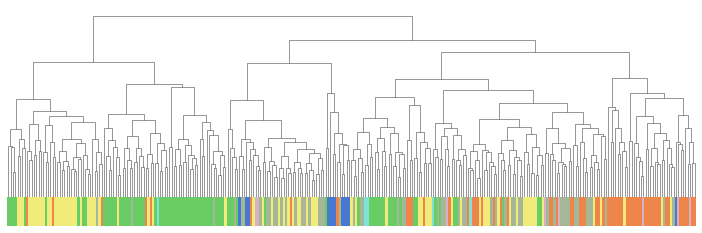

In [45]:
g = sns.clustermap(mrna_total_log_expressions.loc[list(union)].T,
                   method="complete",
                   standard_scale=1,
                   row_colors=color_annotation,
                   col_colors=genes_to_constructs["Color"],
                   cbar_pos=(1, .213, .03, .576),
                   cmap="rocket",
                   figsize=(15, 15))

g.ax_heatmap.set_visible(None)
g.ax_row_dendrogram.set_visible(None)
g.ax_row_colors.set_visible(None)
g.ax_cbar.set_visible(None)
g.ax_col_colors.set_yticks([])

g.savefig(FIGURES_DIR / Path("venn_clustermap_dendrogram.png"), dpi=350)
g.savefig(FIGURES_DIR / Path("venn_clustermap_dendrogram.tiff"), dpi=1200)

## Testing overlap vs. genes exclusive to each construct

In [46]:
sym_dif = set()
overlap = all_genes.copy()
for c in CONSTRUCTS:
    sym_dif ^= downregulated_genes[c] & all_significant_genes[c]
    overlap &= downregulated_genes[c] & all_significant_genes[c]
fall_out_genes = sym_dif - overlap

print("T-test, overlap vs. symmetric difference minus overlap")        
        
fallout_control_mean = mrna_total_log_expressions.loc[list(fall_out_genes)].iloc[:, -3:].mean(axis=1)
overlap_control_mean = mrna_total_log_expressions.loc[list(overlap)].iloc[:, -3:].mean(axis=1)
mean_control_pval = sps.ttest_ind(overlap_control_mean, fallout_control_mean, 
                                  alternative="greater", permutations=permutations_n).pvalue
print(f"mean control expressions:\t{mean_control_pval}")

fallout_l2fc_mean = mrna_total_results.loc[list(fall_out_genes)][[*CONSTRUCTS]].mean(axis=1)
overlap_l2fc_mean = mrna_total_results.loc[list(overlap)][[*CONSTRUCTS]].mean(axis=1)
mean_l2fc_pval = sps.ttest_ind(overlap_l2fc_mean, fallout_l2fc_mean, 
                               alternative="less", permutations=permutations_n).pvalue
print(f"mean log2FoldChange:\t\t{mean_l2fc_pval}")

T-test, overlap vs. symmetric difference minus overlap
mean control expressions:	0.003157996842003158
mean log2FoldChange:		9.99999000001e-07


## Testing overlap vs. all other downregulated genes

In [47]:
union = set()
overlap = all_genes.copy()
for c in CONSTRUCTS:
    union |= downregulated_genes[c] & all_significant_genes[c]
    overlap &= downregulated_genes[c] & all_significant_genes[c]
fall_out_genes = union - overlap

print("T-test, overlap vs. union minus overlap")        
        
fallout_control_mean = mrna_total_log_expressions.loc[list(fall_out_genes)].iloc[:, -3:].mean(axis=1)
overlap_control_mean = mrna_total_log_expressions.loc[list(overlap)].iloc[:, -3:].mean(axis=1)
mean_control_pval = sps.ttest_ind(overlap_control_mean, fallout_control_mean, 
                                  alternative="greater", permutations=permutations_n).pvalue
print(f"mean control expressions:\t{mean_control_pval}")

fallout_l2fc_mean = mrna_total_results.loc[list(fall_out_genes)][[*CONSTRUCTS]].mean(axis=1)
overlap_l2fc_mean = mrna_total_results.loc[list(overlap)][[*CONSTRUCTS]].mean(axis=1)
mean_l2fc_pval = sps.ttest_ind(overlap_l2fc_mean, fallout_l2fc_mean, 
                               alternative="less", permutations=permutations_n).pvalue
print(f"mean log2FoldChange:\t\t{mean_l2fc_pval}")

T-test, overlap vs. union minus overlap
mean control expressions:	0.02230697769302231
mean log2FoldChange:		9.99999000001e-07


# Testing/stats functions

In [48]:
def print_some_stats(target_set,
                     downregulated=downregulated_genes, 
                     all_genes_dict=all_significant_genes):
    table_rows = []
    for construct, downregulated_set in downregulated.items():
        all_genes_set = all_genes_dict[construct]
        if isinstance(target_set, dict):
            target_set = target_set[construct]
        target_set = target_set & all_genes_set
        normal_ratio = len(target_set) / len(all_genes_set) * 100
        
        downregulated_set = downregulated_set & all_genes_set
        downregulated_overlap = len(downregulated_set & target_set)
        downregulated_ratio = downregulated_overlap / len(downregulated_set) * 100
        
        table_rows.append({
            "Downregulated": len(downregulated_set),
            "Downregulated targets": downregulated_overlap, 
            "Share of targets among downregulated": downregulated_ratio,
            "Share of targets among all genes": normal_ratio
        })
    table = pd.DataFrame(table_rows, index=downregulated.keys())
    display(table)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(111, title="Downregulated (shares)")
    ratios = table["Share of targets among downregulated"].values
    bars = plt.bar(downregulated.keys(), ratios)
    plt.bar(downregulated.keys(), [100 - r for r in ratios], bottom=ratios)
    
    x_start = np.array([plt.getp(item, 'x') for item in bars])
    x_end = x_start + [plt.getp(item, 'width') for item in bars]
    plt.hlines(table["Share of targets among all genes"], x_start, x_end, 
               linestyles="--", linewidth=2, color="k")
    
    plt.grid(axis="x")
    plt.ylabel("percentages")
    plt.legend(
        ("expected share of targets", "targets among downregulated", "non-targets among downregulated"),
        loc="upper right"
    )
    plt.show()

In [49]:
def get_drop_contingency_table(construct, 
                               target_set,
                               downregulated,
                               all_genes_dict):
    all_genes_set = all_genes_dict[construct]
    if isinstance(target_set, dict):
        target_set = target_set[construct]
    target_set = target_set & all_genes_set
    if isinstance(downregulated, dict):
        downregulated = downregulated[construct]
    downregulated_set = downregulated & all_genes_set
    
    target_complem_set = all_genes_set - target_set
    downregulated_complem_set = all_genes_set - downregulated_set
    
    nontarget_nondrop = len(target_complem_set & downregulated_complem_set)
    nontarget_drop = len(target_complem_set & downregulated_set)
    target_nondrop = len(target_set & downregulated_complem_set)
    target_drop = len(target_set & downregulated_set)
    
    return np.array([[nontarget_nondrop, target_nondrop],
                     [nontarget_drop, target_drop]])


def run_some_tests(target_set,
                   downregulated=downregulated_genes,
                   all_genes_dict=all_significant_genes):
    table_rows = []
    for construct in CONSTRUCTS:
        drop_table = get_drop_contingency_table(
            construct, 
            target_set, 
            downregulated_genes,
            all_genes_dict
        )

        drop_pval = sps.fisher_exact(drop_table).pvalue
        table_rows.append({
            "Fisher's exact pval": drop_pval,
        })

    table = pd.DataFrame(table_rows, index=CONSTRUCTS)
    table["padj"] = sm.stats.multipletests(table["Fisher's exact pval"], method="fdr_bh")[1]
    
    table = table.style.applymap(
        lambda pval: "background-color: lightgreen" if pval < 0.05 else "",
        subset="padj"
    )
    display(table)

# Main results. Looking for downregulated genes overlapping with reverse complements

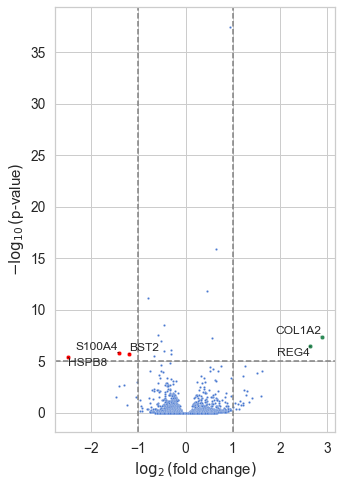

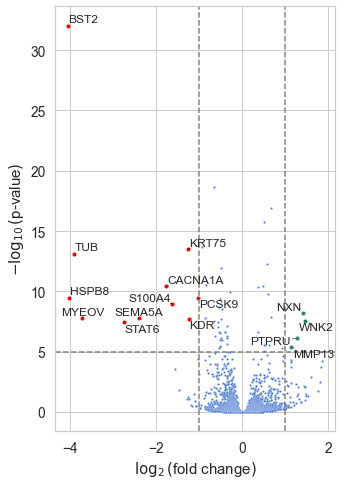

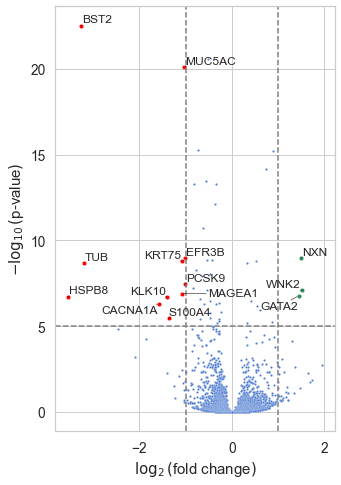

In [50]:
for c in CONSTRUCTS:
    fig = plt.figure(figsize=(5, 7))
    df = mrna_results[c].dropna(axis=0, subset=["log2FoldChange", "padj"])
    df.loc[:, "padj"] = -df["padj"].apply(np.log10)
    ax = sns.scatterplot(data=df, x="log2FoldChange", y="padj", s=5, label="Not significant")
    
    lfc_cutoff = 1
    log_pval_cutoff = -np.log10(1e-5)
    down = df[(df["log2FoldChange"] <= -lfc_cutoff) & (df["padj"] >= log_pval_cutoff)]
    up = df[(df["log2FoldChange"] >= lfc_cutoff) & (df["padj"] >= log_pval_cutoff)]

    sns.scatterplot(data=down, x="log2FoldChange", y="padj", s=20, label="Downregulated", color="red", ax=ax)
    sns.scatterplot(data=up, x="log2FoldChange", y="padj", s=20, label="Upregulated", color="seagreen", ax=ax)
    
    texts=[]
    for i, r in up.iterrows():
        texts.append(plt.text(x=r["log2FoldChange"], y=r["padj"], s=i, fontsize=12))
    for i, r in down.iterrows():
        texts.append(plt.text(x=r["log2FoldChange"], y=r["padj"], s=i, fontsize=12))
    if texts:
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    plt.xlabel("$\log_2($fold change$)$")
    plt.ylabel("$-\log_{10}($p-value$)$")
    plt.axvline(-lfc_cutoff, color="grey", linestyle="--")
    plt.axvline(lfc_cutoff, color="grey", linestyle="--")
    plt.axhline(log_pval_cutoff, color="grey", linestyle="--")
    ax.get_legend().remove()
    
    plt.tight_layout()
    
    plt.savefig(FIGURES_DIR / Path(f"{c}_mRNA_volcano_plot.png"), dpi=350)
    plt.savefig(FIGURES_DIR / Path(f"{c}_mRNA_volcano_plot.tiff"), dpi=1200)

In [51]:
def full_analysis(isomir_num,
                  show_full_seq_7mer=True,
                  show_3_utr_7mer=True,
                  show_full_seq_6mer=True,
                  show_3_utr_6mer=True,
                  show_mirdb=True,
                  show_rna22=True,
                  isomirs_seed=isomirs_7seed):
    seed = isomirs_seed[isomir_num]
    isomir_name = get_isomir_name(isomir_num)
    print("===================================================================================================")
    print(f"IsomiR: {isomir_name}, {seed[:-1]}({seed[-1]})")
    print("---------------------------------------------------------------------------------------------------")
    if show_full_seq_7mer:
        print("Reverse complements (7mer-m8), full gene sequence\n")
        print_some_stats(reverse_complements[seed])
        run_some_tests(reverse_complements[seed])
        print("-----------------------------------------------------------------------------------------------")
    if show_full_seq_6mer:
        print("Reverse complements (6mer), full gene sequence\n")
        print_some_stats(reverse_complements_6mer[seed[:-1]])
        run_some_tests(reverse_complements_6mer[seed[:-1]])
        print("-----------------------------------------------------------------------------------------------")
        
    if show_3_utr_7mer:
        print("Reverse complements (7mer-m8), at least in 3'-UTR\n")
        print_some_stats(reverse_complements_3utr[seed])
        run_some_tests(reverse_complements_3utr[seed])
        print("-----------------------------------------------------------------------------------------------")
    if show_3_utr_6mer:
        print("Reverse complements (6mer), at least in 3'-UTR\n")
        print_some_stats(reverse_complements_3utr_6mer[seed[:-1]])
        run_some_tests(reverse_complements_3utr_6mer[seed[:-1]])
        print("-----------------------------------------------------------------------------------------------")
        
    if show_mirdb:
        print("miRDB predicted targets\n")
        print_some_stats(mirdb_targets[isomir_num])
        run_some_tests(mirdb_targets[isomir_num])
        print("-----------------------------------------------------------------------------------------------")
    if show_rna22 and isomir_num >= 0:
        print("RNA22 predicted targets\n")
        print_some_stats(rna22_targets[isomir_num])
        run_some_tests(rna22_targets[isomir_num])
        print("-----------------------------------------------------------------------------------------------")
    print("===================================================================================================")
    print()

In [52]:
rows = []
for isomir_num in [0, 3, 4, 5]:
    seed = isomirs_7seed[isomir_num]
    name = get_isomir_name(isomir_num)
    for c in CONSTRUCTS:
        targets_mirdb = mirdb_targets[isomir_num] & all_significant_genes[c]
        targets_rna22 = rna22_targets[isomir_num] & all_significant_genes[c]
        targets_full = reverse_complements[seed] & all_significant_genes[c]
        targets_3utr = reverse_complements_3utr[seed] & all_significant_genes[c]
        targets_full_6mer = reverse_complements_6mer[seed[:-1]] & all_significant_genes[c]
        targets_3utr_6mer = reverse_complements_3utr_6mer[seed[:-1]] & all_significant_genes[c]
        
        drop_table = get_drop_contingency_table(c, targets_mirdb, downregulated_genes, all_significant_genes)
        rows.append({
            "IsomiR": name,
            "Group": c,
            "Target type": "miRDB",
            "P-value (Fisher)": sps.fisher_exact(drop_table).pvalue
        })
        drop_table = get_drop_contingency_table(c, targets_rna22, downregulated_genes, all_significant_genes)
        rows.append({
            "IsomiR": name,
            "Group": c,
            "Target type": "RNA22",
            "P-value (Fisher)": sps.fisher_exact(drop_table).pvalue
        })
        drop_table = get_drop_contingency_table(c, targets_full_6mer, downregulated_genes, all_significant_genes)
        rows.append({
            "IsomiR": name,
            "Group": c,
            "Target type": "Full sequence (6mer)",
            "P-value (Fisher)": sps.fisher_exact(drop_table).pvalue
        })
        drop_table = get_drop_contingency_table(c, targets_3utr_6mer, downregulated_genes, all_significant_genes)
        rows.append({
            "IsomiR": name,
            "Group": c,
            "Target type": "3'-UTR (6mer)",
            "P-value (Fisher)": sps.fisher_exact(drop_table).pvalue
        })
        drop_table = get_drop_contingency_table(c, targets_full, downregulated_genes, all_significant_genes)
        rows.append({
            "IsomiR": name,
            "Group": c,
            "Target type": "Full sequence (7mer-m8)",
            "P-value (Fisher)": sps.fisher_exact(drop_table).pvalue
        })
        drop_table = get_drop_contingency_table(c, targets_3utr, downregulated_genes, all_significant_genes)
        rows.append({
            "IsomiR": name,
            "Group": c,
            "Target type": "3'-UTR (7mer-m8)",
            "P-value (Fisher)": sps.fisher_exact(drop_table).pvalue
        })
df = pd.DataFrame(rows)

mask = df["Target type"] == "miRDB"
pvals = df.loc[mask, "P-value (Fisher)"]
df.loc[mask, "Adjusted p-value"] = sm.stats.multipletests(pvals, method="fdr_bh")[1]

mask = df["Target type"] == "RNA22"
pvals = df.loc[mask, "P-value (Fisher)"]
df.loc[mask, "Adjusted p-value"] = sm.stats.multipletests(pvals, method="fdr_bh")[1]

mask = df["Target type"] == "Full sequence (7mer-m8)"
pvals = df.loc[mask, "P-value (Fisher)"]
df.loc[mask, "Adjusted p-value"] = sm.stats.multipletests(pvals, method="fdr_bh")[1]

mask = df["Target type"] == "3'-UTR (7mer-m8)"
pvals = df.loc[mask, "P-value (Fisher)"]
df.loc[mask, "Adjusted p-value"] = sm.stats.multipletests(pvals, method="fdr_bh")[1]

mask = df["Target type"] == "Full sequence (6mer)"
pvals = df.loc[mask, "P-value (Fisher)"]
df.loc[mask, "Adjusted p-value"] = sm.stats.multipletests(pvals, method="fdr_bh")[1]

mask = df["Target type"] == "3'-UTR (6mer)"
pvals = df.loc[mask, "P-value (Fisher)"]
df.loc[mask, "Adjusted p-value"] = sm.stats.multipletests(pvals, method="fdr_bh")[1]

df = df.sort_values(["IsomiR", "Target type"]).set_index(["IsomiR", "Target type", "Group"])
display(
    df
    .style
    .applymap(
        lambda p: "background-color: lightgreen" if p < 0.05 else "", subset="Adjusted p-value"
    )
)

# print(df.to_latex(bold_rows=True, escape=True))

# Sensitivity and specificity

In [53]:
def sensitivity_specificity(target_dict, target_name,
                            isomirs_seed=isomirs_7seed,
                            isomir_nums=[0, 3, 4, 5],
                            downregulated_dict=downregulated_genes,
                            enclosing_dict=all_significant_genes):
    rows = []
    for isomir_num in isomir_nums:
        isomir_seed_seq = isomirs_seed[isomir_num]
        targets = target_dict[isomir_seed_seq]
        isomir_name = get_isomir_name(isomir_num)
        for c in CONSTRUCTS:
            enclosing = enclosing_dict[c]
            downregulated = downregulated_dict[c] & enclosing
            TP = len(targets & downregulated)
            P = len(downregulated)
            TN = len((enclosing - targets) & (enclosing - downregulated))
            N = len(enclosing - downregulated)
            baseline_sensitivity = len(targets & enclosing) / len(enclosing)
            baseline_specificity = 1 - baseline_sensitivity
            sensitivity = TP / P
            specificity = TN / N
            rows.append({
                "IsomiR": isomir_name,
                "Metric": "sensitivity",
                "Group": c,
                "Target type": target_name,
                "Metric value": sensitivity,
                "Reference metric value": baseline_sensitivity,
                "Reference ratio difference": abs(sensitivity - baseline_sensitivity)
            })
            rows.append({
                "IsomiR": isomir_name,
                "Metric": "specificity",
                "Group": c,
                "Target type": target_name,
                "Metric value": specificity,
                "Reference metric value": baseline_specificity,
                "Reference ratio difference": abs(specificity - baseline_specificity)
            })
    return pd.DataFrame(rows)

## 6mer

In [54]:
df = pd.concat((
    sensitivity_specificity({isomirs_7seed[k]: v for k, v in mirdb_targets.items()}, "miRDB"),
    sensitivity_specificity({isomirs_7seed[k]: v for k, v in rna22_targets.items()}, "RNA22"),
    sensitivity_specificity(reverse_complements_3utr_6mer, "3'UTR", isomirs_seed=isomirs_6seed),
    sensitivity_specificity(reverse_complements_6mer, "Full seq", isomirs_seed=isomirs_6seed),
    
))
df_0 = df[df.IsomiR == f"{MIR_NAME}|0"]
df_345 = df[df.IsomiR != f"{MIR_NAME}|0"]

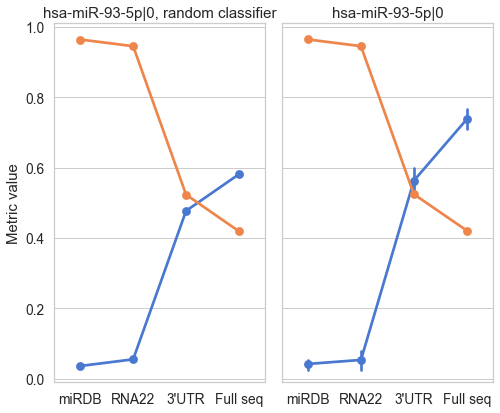

In [55]:
g = sns.catplot(
    data=df_0.melt(
        id_vars=df_0.columns[:-3],
        value_vars=["Reference metric value", "Metric value"]
    ),
    x="Target type", y="value",
    hue="Metric", col="variable",
    kind="point",
    height=6, aspect=0.6, legend=False, facet_kws=dict(ylim=(-0.01, 1.01))
)

g.despine(top=False, right=False)
g.set_titles(col_template=f"{MIR_NAME}|0")
g.axes[0, 0].set_title(f"{MIR_NAME}|0, random classifier")
g.set_xlabels(label="")
g.set_ylabels(label="Metric value")

g.tight_layout()

g.savefig(FIGURES_DIR / Path("sensitivity_specificity_6mer_0.png"), dpi=350)
g.savefig(FIGURES_DIR / Path("sensitivity_specificity_6mer_0.tiff"), dpi=1200)

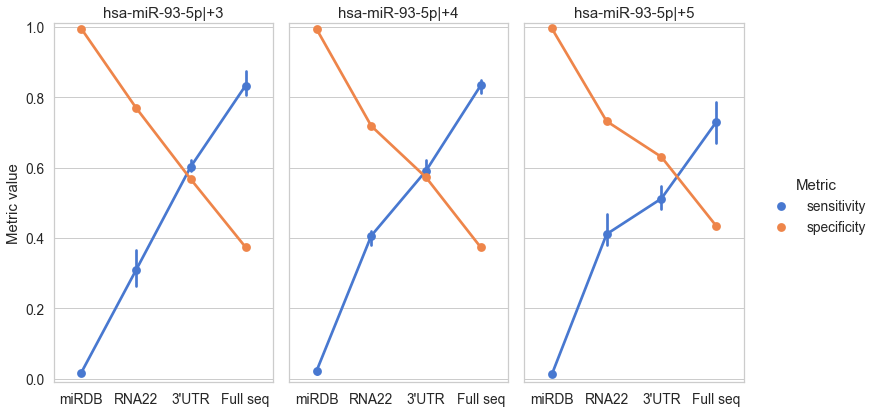

In [56]:
g = sns.catplot(
    data=df_345, x="Target type", y="Metric value",
    col="IsomiR", hue="Metric",
    kind="point", height=6, aspect=0.6, facet_kws=dict(ylim=(-0.01, 1.01))
)
g.despine(top=False, right=False)
g.set_titles(col_template="{col_name}")
g.set_xlabels(label="")

g.tight_layout()

g.savefig(FIGURES_DIR / Path("sensitivity_specificity_6mer_345.png"), dpi=350)
g.savefig(FIGURES_DIR / Path("sensitivity_specificity_6mer_345.tiff"), dpi=1200)

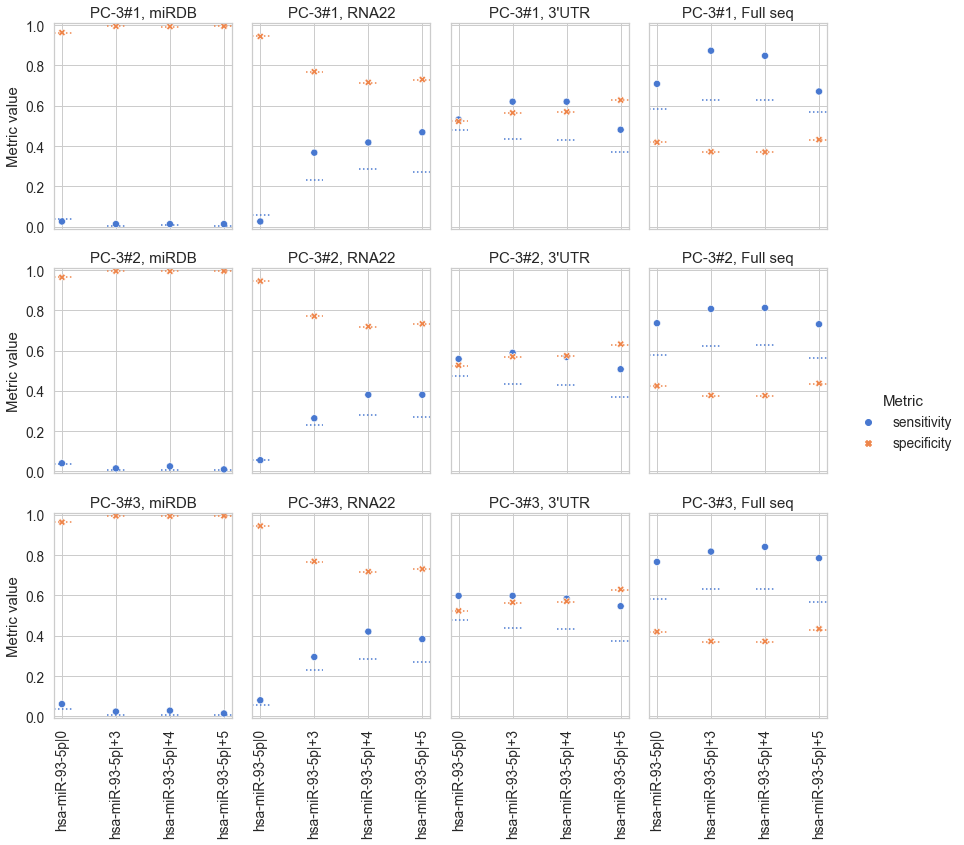

In [57]:
g = sns.relplot(
    data=df, x="IsomiR", y="Metric value",
    row="Group", col="Target type", hue="Metric", style="Metric",
    kind="scatter", s=50, facet_kws=dict(ylim=(-0.01, 1.01)), height=4, aspect=0.75
)

for (c, tt) in g.axes_dict:
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|0")
            & (df["Metric"] == "sensitivity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        xmax=0.1,
        label="Reference sensitivity"
    )
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|0")
            & (df["Metric"] == "specificity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        c=GROUP_COLORS[1],
        xmax=0.1,
        label="Reference specificity"
    )
    
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|+3")
            & (df["Metric"] == "sensitivity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        xmin=0.3,
        xmax=0.4,
        label="Reference sensitivity"
    )
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|+3")
            & (df["Metric"] == "specificity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        c=GROUP_COLORS[1],
        xmin=0.3,
        xmax=0.4,
        label="Reference specificity"
    )
    
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|+4")
            & (df["Metric"] == "sensitivity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        xmin=0.6,
        xmax=0.7,
        label="Reference sensitivity"
    )
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|+4")
            & (df["Metric"] == "specificity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        c=GROUP_COLORS[1],
        xmin=0.6,
        xmax=0.7,
        label="Reference specificity"
    )
    
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|+5")
            & (df["Metric"] == "sensitivity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        xmin=0.9,
        label="Reference sensitivity"
    )
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|+5")
            & (df["Metric"] == "specificity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        c=GROUP_COLORS[1],
        xmin=0.9,
        label="Reference specificity"
    )

g.tick_params(axis="x", rotation=90)
g.despine(top=False, right=False)
g.set_titles(template="{row_name}, {col_name}")
g.set_xlabels(label="")

g.tight_layout()

g.savefig(FIGURES_DIR / Path("sensitivity_specificity_6mer_full.png"), dpi=350)
g.savefig(FIGURES_DIR / Path("sensitivity_specificity_6mer_full.tiff"), dpi=1200)

## 7mer-m8

In [58]:
df = pd.concat((
    sensitivity_specificity({isomirs_7seed[k]: v for k, v in mirdb_targets.items()}, "miRDB"),
    sensitivity_specificity({isomirs_7seed[k]: v for k, v in rna22_targets.items()}, "RNA22"),
    sensitivity_specificity(reverse_complements_3utr, "3'UTR", isomirs_seed=isomirs_7seed),
    sensitivity_specificity(reverse_complements, "Full seq", isomirs_seed=isomirs_7seed),
    
))
df_0 = df[df.IsomiR == f"{MIR_NAME}|0"]
df_345 = df[df.IsomiR != f"{MIR_NAME}|0"]

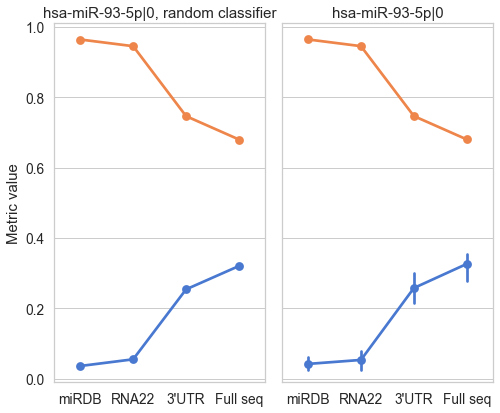

In [59]:
g = sns.catplot(
    data=df_0.melt(
        id_vars=df_0.columns[:-3],
        value_vars=["Reference metric value", "Metric value"]
    ),
    x="Target type", y="value",
    hue="Metric", col="variable",
    kind="point",
    height=6, aspect=0.6, legend=False, facet_kws=dict(ylim=(-0.01, 1.01))
)

g.despine(top=False, right=False)
g.set_titles(col_template=f"{MIR_NAME}|0")
g.axes[0, 0].set_title(f"{MIR_NAME}|0, random classifier")
g.set_xlabels(label="")
g.set_ylabels(label="Metric value")

g.tight_layout()

g.savefig(FIGURES_DIR / Path("sensitivity_specificity_7mer_0.png"), dpi=350)
g.savefig(FIGURES_DIR / Path("sensitivity_specificity_7mer_0.tiff"), dpi=1200)

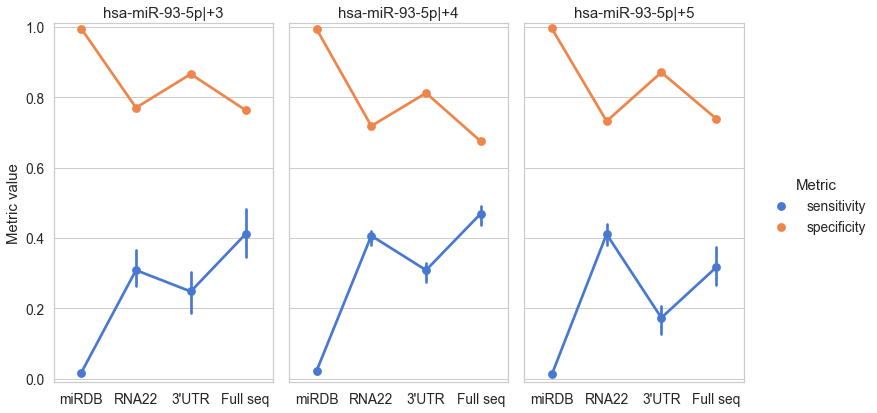

In [60]:
g = sns.catplot(
    data=df_345, x="Target type", y="Metric value",
    col="IsomiR", hue="Metric",
    kind="point", height=6, aspect=0.6, facet_kws=dict(ylim=(-0.01, 1.01))
)
g.despine(top=False, right=False)
g.set_titles(col_template="{col_name}")
g.set_xlabels(label="")

g.tight_layout()

g.savefig(FIGURES_DIR / Path("sensitivity_specificity_7mer_345.png"), dpi=350)
g.savefig(FIGURES_DIR / Path("sensitivity_specificity_7mer_345.tiff"), dpi=1200)

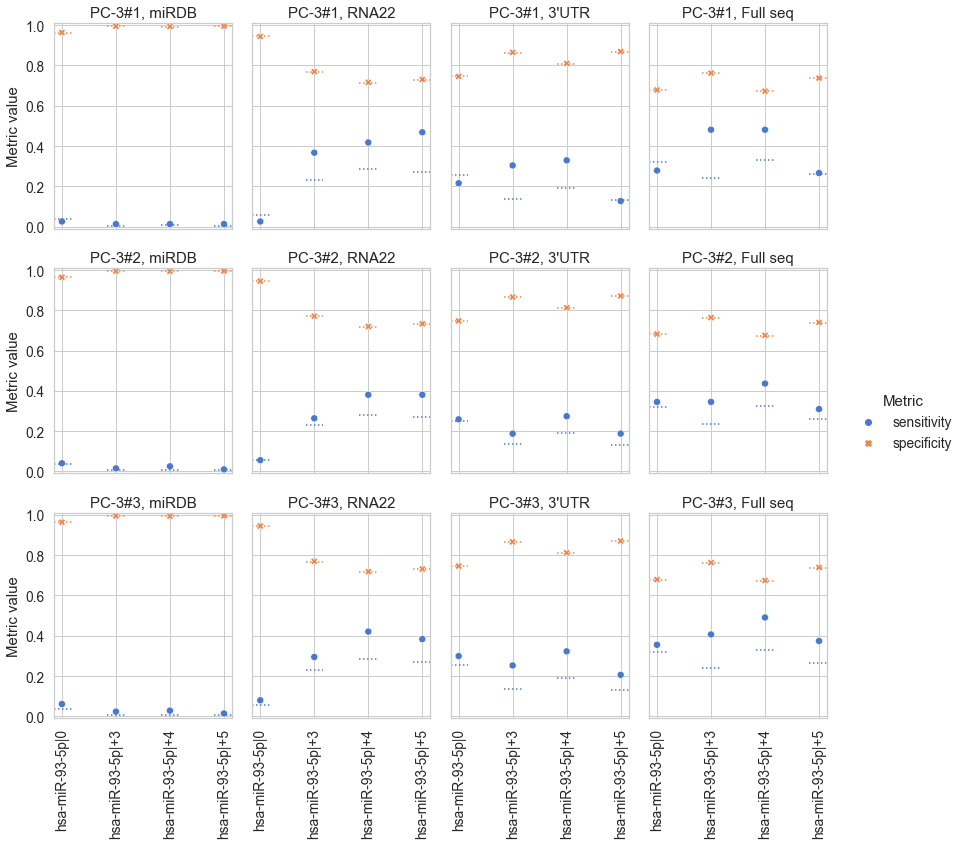

In [61]:
g = sns.relplot(
    data=df, x="IsomiR", y="Metric value",
    row="Group", col="Target type", hue="Metric", style="Metric",
    kind="scatter", s=50, facet_kws=dict(ylim=(-0.01, 1.01)), height=4, aspect=0.75
)

for (c, tt) in g.axes_dict:
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|0")
            & (df["Metric"] == "sensitivity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        xmax=0.1,
        label="Reference sensitivity"
    )
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|0")
            & (df["Metric"] == "specificity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        c=GROUP_COLORS[1],
        xmax=0.1,
        label="Reference specificity"
    )
    
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|+3")
            & (df["Metric"] == "sensitivity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        xmin=0.3,
        xmax=0.4,
        label="Reference sensitivity"
    )
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|+3")
            & (df["Metric"] == "specificity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        c=GROUP_COLORS[1],
        xmin=0.3,
        xmax=0.4,
        label="Reference specificity"
    )
    
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|+4")
            & (df["Metric"] == "sensitivity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        xmin=0.6,
        xmax=0.7,
        label="Reference sensitivity"
    )
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|+4")
            & (df["Metric"] == "specificity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        c=GROUP_COLORS[1],
        xmin=0.6,
        xmax=0.7,
        label="Reference specificity"
    )
    
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|+5")
            & (df["Metric"] == "sensitivity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        xmin=0.9,
        label="Reference sensitivity"
    )
    g.axes_dict[(c, tt)].axhline(
        df.loc[
            (df["IsomiR"] == f"{MIR_NAME}|+5")
            & (df["Metric"] == "specificity")
            & (df["Group"] == c)
            & (df["Target type"] == tt),
        "Reference metric value"
        ].values,
        linestyle="dotted",
        c=GROUP_COLORS[1],
        xmin=0.9,
        label="Reference specificity"
    )

g.tick_params(axis="x", rotation=90)
g.despine(top=False, right=False)
g.set_titles(template="{row_name}, {col_name}")
g.set_xlabels(label="")

g.tight_layout()

g.savefig(FIGURES_DIR / Path("sensitivity_specificity_7mer_full.png"), dpi=350)
g.savefig(FIGURES_DIR / Path("sensitivity_specificity_7mer_full.tiff"), dpi=1200)

# Loading PC-3 miRNA-Seq data

In [62]:
mirna_counts = {}
mirna_log_expressions = {}
mirna_results = {}
mirna_total_results = None

for c, cdir in zip(CONSTRUCTS, CONSTRUCTS_DIRS):
    cpath = PC3_MIRNA_RESULTS_DIR / cdir
    mirna_counts[c] = pd.read_table(cpath / "isoMiRmap_exclusive_counts.tsv", index_col=0)
    mirna_counts[c].columns = mirna_counts[c].columns.str.removesuffix("_R1_001.fastq")
    mirna_counts[c].index = mirna_counts[c].index.str.split("?", expand=True).droplevel([2, 3])
    
    mirna_log_expressions[c] = pd.read_table(cpath / "isoMiRmap_exclusive_log2_RPM_DESeq2.tsv", index_col=0)
    mirna_log_expressions[c].columns = mirna_log_expressions[c].columns.str.removesuffix("_R1_001.fastq")
    mirna_log_expressions[c].index = mirna_log_expressions[c].index.str.split("?", expand=True).droplevel([2, 3])
    
    mirna_results[c] = pd.read_table(cpath / "overexp_vs_control_all.tsv", index_col=-1)
    mirna_results[c].index = mirna_results[c].index.str.split("?", expand=True).droplevel([2, 3])
    
    
    if mirna_total_results is None:
        mirna_total_results = pd.DataFrame(index=mirna_results[c].index)

    not_significant = mirna_results[c].padj > 0.05
    mirna_total_results[c] = mirna_results[c].log2FoldChange
    mirna_total_results[c].loc[not_significant[not_significant].index] = 0

mirna_total_counts = pd.read_table(
    PC3_MIRNA_RESULTS_DIR / "PC3" / "isoMiRmap_exclusive_counts.tsv", index_col=0)
mirna_total_counts.columns = mirna_total_counts.columns.str.removesuffix("_R1_001.fastq")
mirna_total_counts.index = mirna_total_counts.index.str.split("?", expand=True).droplevel([2, 3])

mirna_total_log_expressions = pd.read_table(
    PC3_MIRNA_RESULTS_DIR / "PC3" / "isoMiRmap_exclusive_log2_RPM_DESeq2.tsv", index_col=0)
mirna_total_log_expressions.columns = mirna_total_log_expressions.columns.str.removesuffix("_R1_001.fastq")
mirna_total_log_expressions.index = mirna_total_log_expressions.index.str.split("?", expand=True).droplevel([2, 3])

In [63]:
mirna_counts_5prime = {}
mirna_log_expressions_5prime = {}
mirna_results_5prime = {}
mirna_total_results_5prime = None

for c, cdir in zip(CONSTRUCTS, CONSTRUCTS_DIRS):
    cpath = PC3_MIRNA_RESULTS_DIR / cdir
    mirna_counts_5prime[c] = pd.read_table(cpath / "5prime_isoMiRmap_exclusive_counts.tsv", index_col=0)
    mirna_counts_5prime[c].columns = mirna_counts_5prime[c].columns.str.removesuffix("_R1_001.fastq")
    mirna_log_expressions_5prime[c] = pd.read_table(
        cpath / "5prime_isoMiRmap_exclusive_log2_RPM_DESeq2.tsv", 
        index_col=0
    )
    mirna_log_expressions_5prime[c].columns = mirna_log_expressions_5prime[c].columns.str.removesuffix("_R1_001.fastq")
    mirna_results_5prime[c] = pd.read_table(cpath / "5prime_overexp_vs_control_all.tsv", index_col=-1)
    
    if mirna_total_results_5prime is None:
        mirna_total_results_5prime = pd.DataFrame(index=mirna_results_5prime[c].index)

    not_significant = mirna_results_5prime[c].padj > 0.05
    mirna_total_results_5prime[c] = mirna_results_5prime[c].log2FoldChange
    mirna_total_results_5prime[c].loc[not_significant[not_significant].index] = 0

mirna_total_counts_5prime = pd.read_table(
    PC3_MIRNA_RESULTS_DIR / "PC3" / "5prime_isoMiRmap_exclusive_counts.tsv", index_col=0)
mirna_total_counts_5prime.columns = mirna_total_counts_5prime.columns.str.removesuffix("_R1_001.fastq")

mirna_total_log_expressions_5prime = pd.read_table(
    PC3_MIRNA_RESULTS_DIR / "PC3" / "5prime_isoMiRmap_exclusive_log2_RPM_DESeq2.tsv", index_col=0)
mirna_total_log_expressions_5prime.columns = mirna_total_log_expressions_5prime.columns.str.removesuffix("_R1_001.fastq")

mirna_total_annotation = pd.read_table(PC3_MIRNA_RESULTS_DIR / "PC3" / "description.tsv", index_col=0)
mirna_total_annotation.index = mirna_total_annotation.index.str.removesuffix("_R1_001.fastq")
mirna_total_annotation.loc[mirna_total_annotation.index.str.startswith("PC3_6"), "Group"] += "6"
mirna_total_annotation.loc[mirna_total_annotation.index.str.startswith("PC3_7"), "Group"] += "7"
mirna_total_annotation.loc[mirna_total_annotation.index.str.startswith("PC3_8"), "Group"] += "8"
mirna_total_annotation = mirna_total_annotation.replace(
    dict(zip(mirna_total_annotation.Group.unique(), [*CONSTRUCTS, "Control"]))
)

## Quality control

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 14.48 seconds.

Fitting dispersion trend curve...
... done in 26.38 seconds.



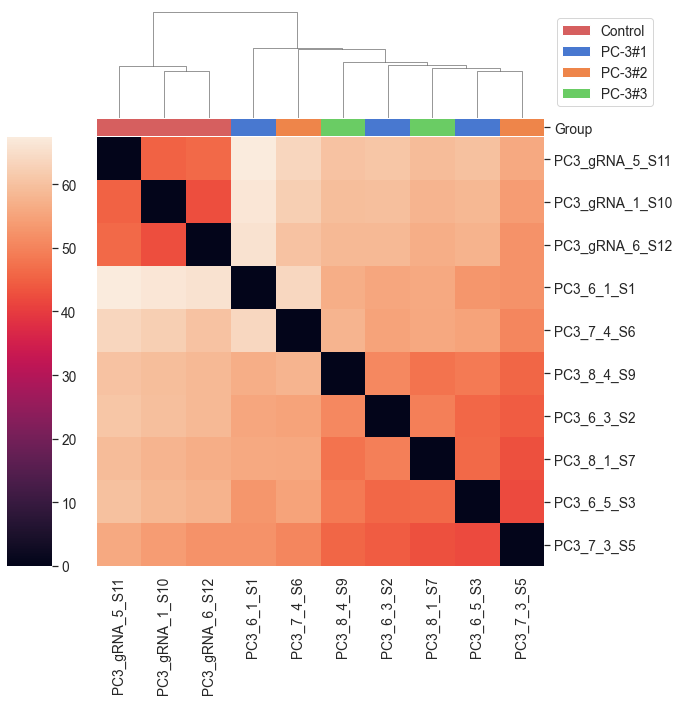

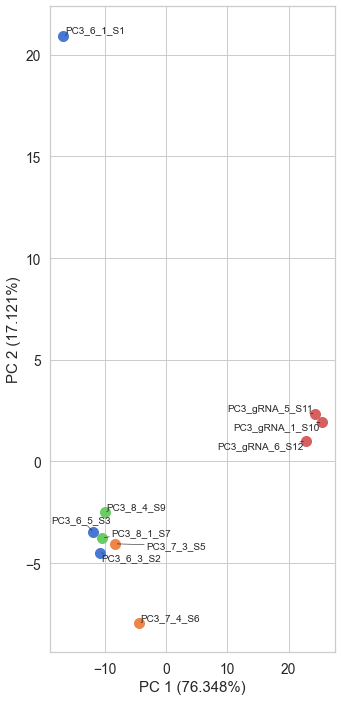

In [64]:
if "mirna_dds" not in globals():
    mirna_dds = DeseqDataSet(
        counts=mirna_total_counts.reset_index(level=1).drop(columns="level_1").T,
        clinical=mirna_total_annotation,
        design_factors=mirna_total_annotation.columns[0]
    )
    mirna_dds.vst()
    
pca_explorer_analysis(
    mirna_total_counts, mirna_total_annotation,
    dds=mirna_dds, clist=GROUP_COLORS, save=True, name="miRNA", cbar_pos=(0.054, 0.20, 0.062, 0.596)
)

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.98 seconds.

Fitting dispersion trend curve...
... done in 3.89 seconds.



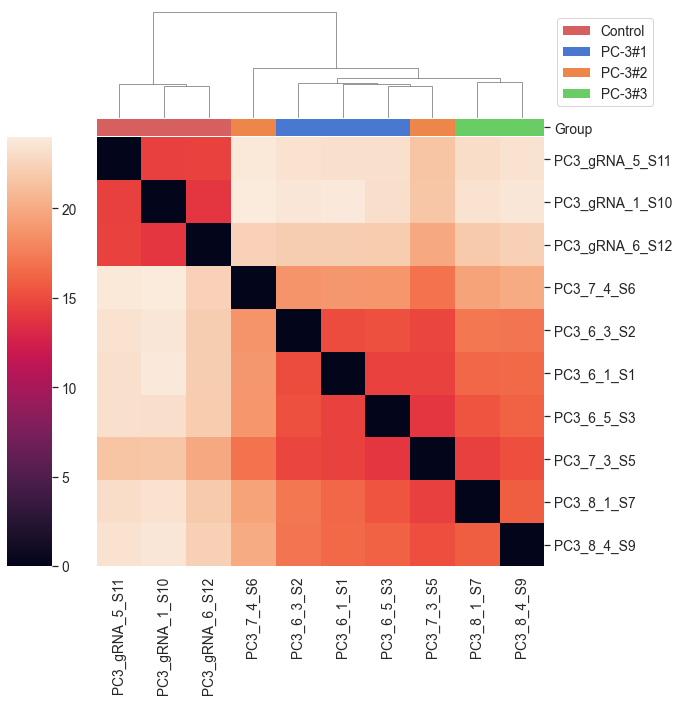

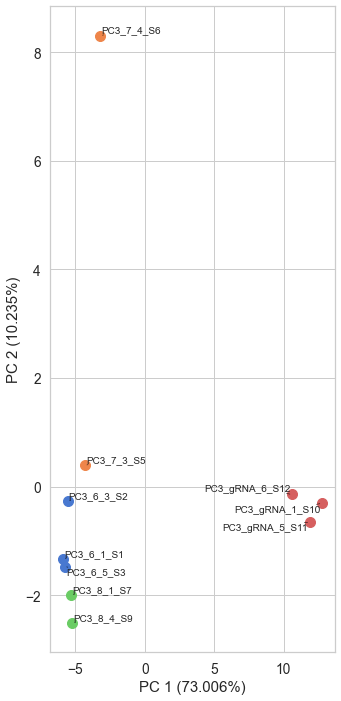

In [65]:
if "mirna_5prime_dds" not in globals():
    mirna_5prime_dds = DeseqDataSet(
        counts=mirna_total_counts_5prime.T,
        clinical=mirna_total_annotation,
        design_factors=mirna_total_annotation.columns[0]
    )
    mirna_5prime_dds.vst()

pca_explorer_analysis(
    mirna_total_counts_5prime, mirna_total_annotation,
    dds=mirna_5prime_dds, clist=GROUP_COLORS, save=True, name="miRNA_5prime", cbar_pos=(0.054, 0.20, 0.062, 0.596)
)

# Investigating differences in distributions after overexpression

In [66]:
color_annotation = mirna_total_annotation.replace(dict(zip(mirna_total_annotation.Group.unique(), GROUP_COLORS)))

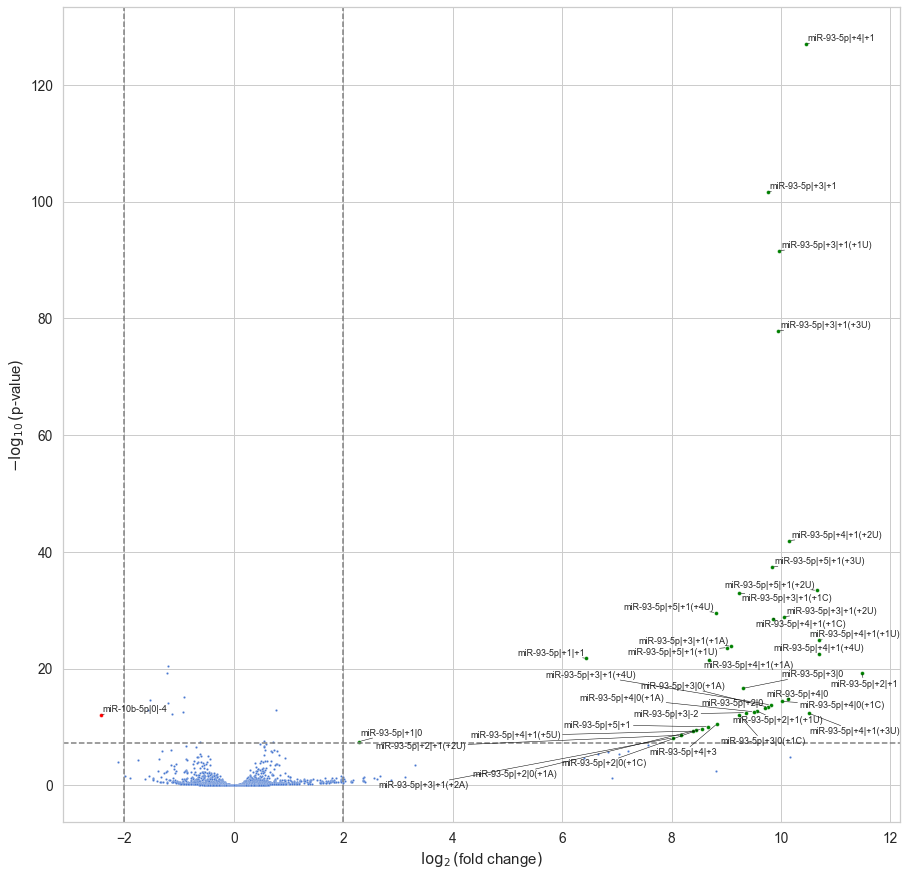

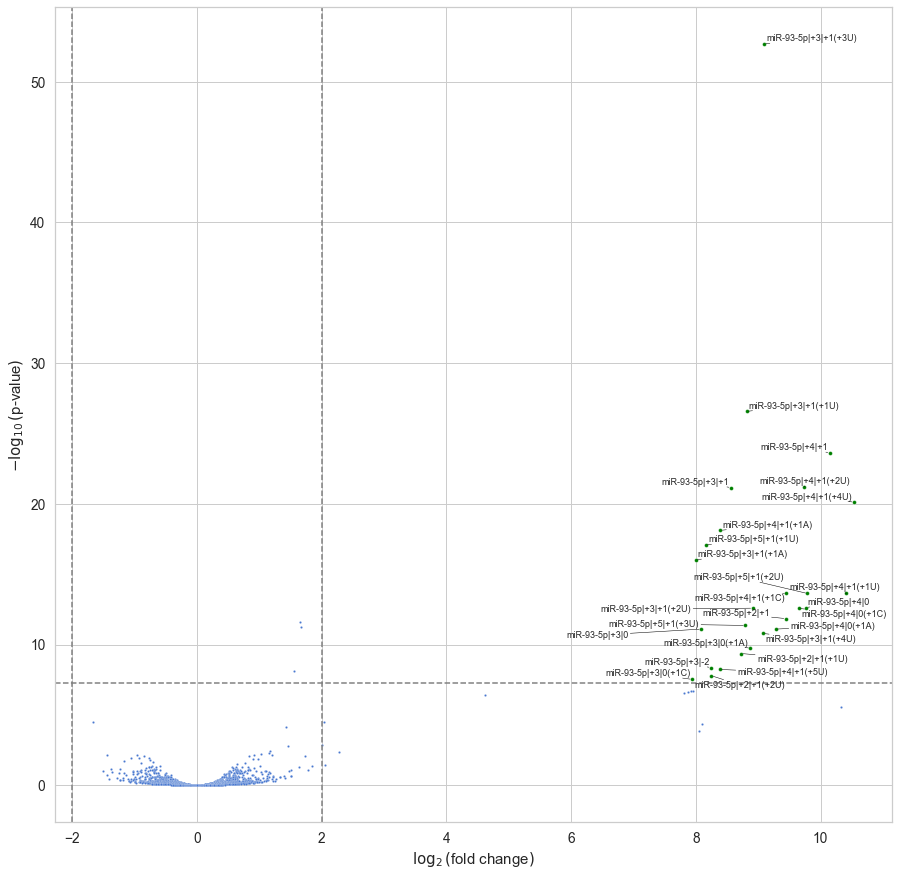

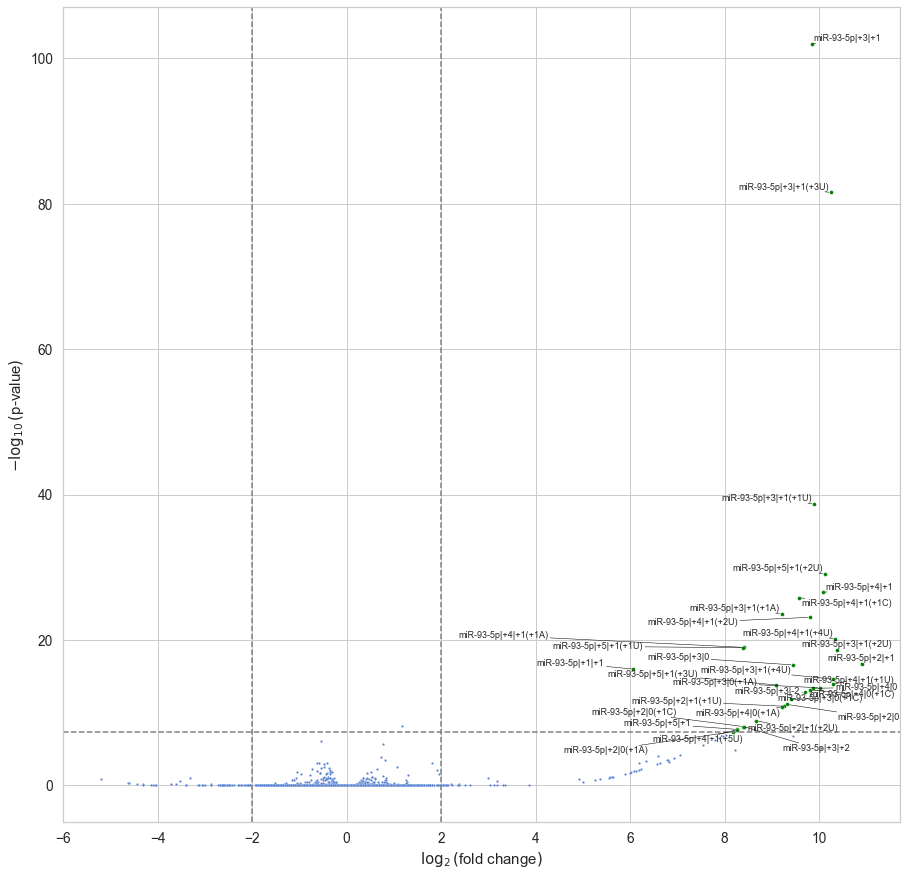

In [67]:
for c in CONSTRUCTS:
    fig = plt.figure(figsize=(15, 15))
    df = mirna_results[c].reset_index(level=0).dropna(axis=0, subset=["log2FoldChange", "padj"])
    df.index = df.index.str.removeprefix("hsa-")
    df["padj"] = -df["padj"].apply(np.log10)
    ax = sns.scatterplot(data=df, x="log2FoldChange", y="padj", s=5, label="Not significant")
    
    lfc_cutoff = 2
    log_pval_cutoff = -np.log10(5e-8)
    down = df[(df["log2FoldChange"] <= -lfc_cutoff) & (df["padj"] >= log_pval_cutoff)]
    up = df[(df["log2FoldChange"] >= lfc_cutoff) & (df["padj"] >= log_pval_cutoff)]

    sns.scatterplot(data=down, x="log2FoldChange", y="padj", s=15, label="Downregulated", color="red", ax=ax)
    sns.scatterplot(data=up, x="log2FoldChange", y="padj", s=15, label="Upregulated", color="green", ax=ax)
    
    texts=[]
    for i, r in up.iterrows():
        texts.append(plt.text(x=r["log2FoldChange"], y=r["padj"], s=i, fontsize=9))
    for i, r in down.iterrows():
        texts.append(plt.text(x=r["log2FoldChange"], y=r["padj"], s=i, fontsize=9))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    plt.xlabel("$\log_2($fold change$)$")
    plt.ylabel("$-\log_{10}($p-value$)$")
    plt.axvline(-lfc_cutoff, color="grey", linestyle="--")
    plt.axvline(lfc_cutoff, color="grey", linestyle="--")
    plt.axhline(log_pval_cutoff, color="grey", linestyle="--")
    ax.get_legend().remove()
    plt.show()

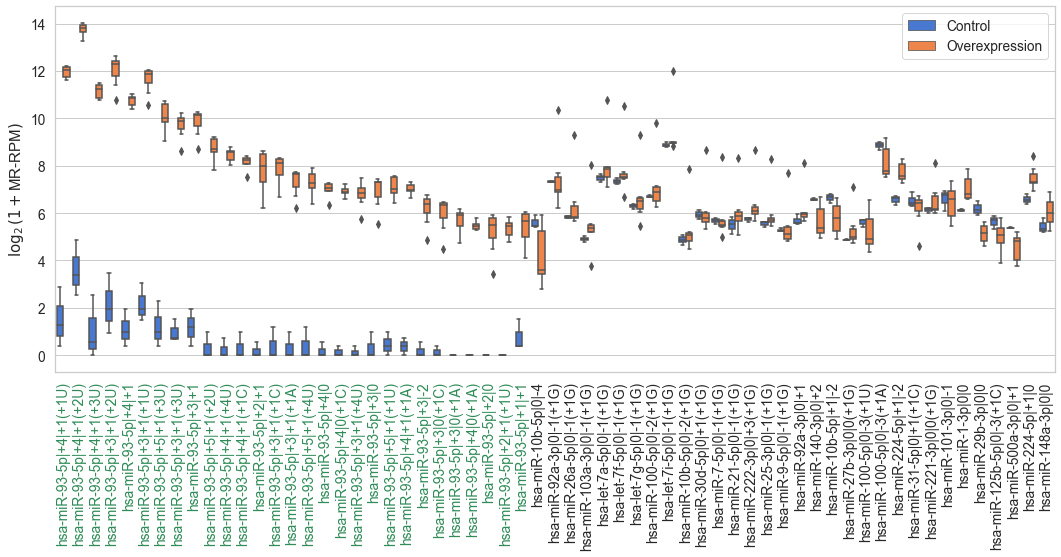

In [68]:
std_sort_idx = mirna_total_log_expressions.std(axis=1).sort_values(ascending=False).index[:1000]
median_sort_idx = mirna_total_log_expressions.median(axis=1).sort_values(ascending=False).index[:1000]

df = (
    mirna_total_log_expressions
    .loc[std_sort_idx.intersection(median_sort_idx)]
    .reset_index(level=0)
    .drop(columns="level_0")
)
df = df.reset_index().melt(id_vars="index")
df.loc[df["variable"].str.startswith(("PC3_6", "PC3_7", "PC3_8")), "Group"] = "Overexpression"
df.loc[df["variable"].str.startswith("PC3_gRNA"), "Group"] = "Control"

plt.figure(figsize=(15, 8))
ax = sns.boxplot(df, x="index", y="value", hue="Group", hue_order=["Control", "Overexpression"], saturation=1)
plt.xticks(rotation=90, ha="center")
for t in ax.get_xticklabels():
    if t.get_text().startswith(MIR_NAME):
        t.set_color("seagreen")
ax.set_xlabel(None)
ax.set_ylabel("$\log_2(1+$MR-RPM$)$")
ax.legend(title=None)

plt.tight_layout()

plt.savefig(FIGURES_DIR / Path("isomiRs_profile.png"), dpi=350)
plt.savefig(FIGURES_DIR / Path("isomiRs_profile.tiff"), dpi=1200)

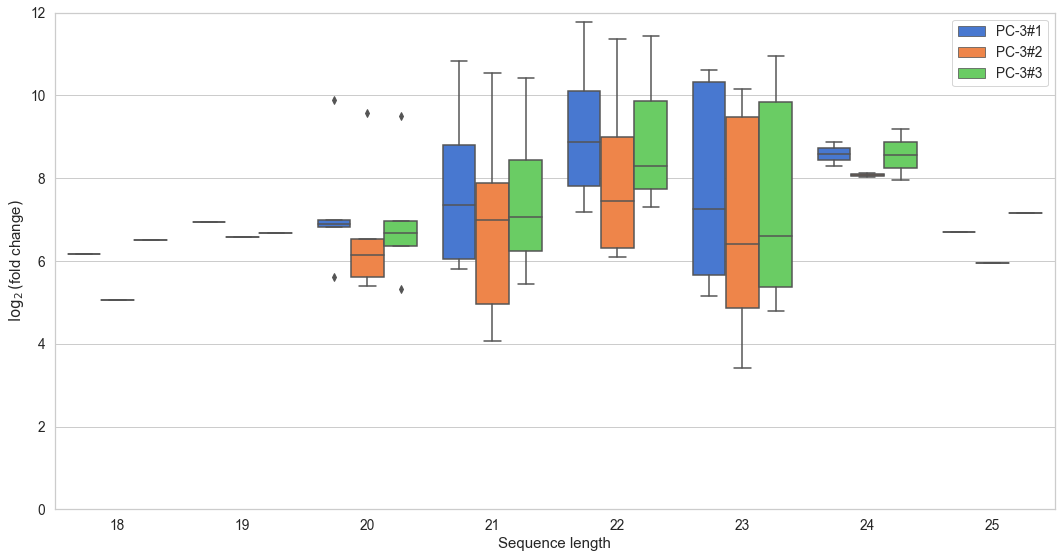

In [69]:
df = (
    mirna_total_log_expressions
    .loc[std_sort_idx.intersection(median_sort_idx)]
    .reset_index(level=0)
)
df = df[df.index.str.startswith(MIR_NAME)]
lengths = df.level_0.str.len()
df = df.drop(columns="level_0")

control_cols = df.columns[df.columns.str.startswith("PC3_gRNA")]
control_means = df[control_cols].mean(axis=1)
pc3_6_cols = df.columns[df.columns.str.startswith("PC3_6")]
pc3_7_cols = df.columns[df.columns.str.startswith("PC3_7")]
pc3_8_cols = df.columns[df.columns.str.startswith("PC3_8")]

df = 2**df - 1

df[CONSTRUCTS[0]] = np.log2(df[pc3_6_cols].mean(axis=1) + 1) - np.log2(control_means + 1)
df[CONSTRUCTS[1]] = np.log2(df[pc3_7_cols].mean(axis=1) + 1) - np.log2(control_means + 1)
df[CONSTRUCTS[2]] = np.log2(df[pc3_8_cols].mean(axis=1) + 1) - np.log2(control_means + 1)
df = df[list(CONSTRUCTS)]
df.index = lengths

pval_tab = pd.DataFrame(
    data=[sps.mannwhitneyu(df[~(df.index == 22)], df[df.index == 22], alternative="less").pvalue],
    columns=CONSTRUCTS,
    index=["mannwhitneyu_pval"]
)

df = df.reset_index(names="length").melt(id_vars="length")

plt.figure(figsize=(15, 8))
ax = sns.boxplot(df, x="length", y="value", hue="variable", saturation=1)
ax.set_ylim((0, 12))
ax.set_xlabel("Sequence length")
ax.set_ylabel("$\log_2($fold change$)$")
ax.legend(title=None)

plt.tight_layout()

plt.savefig(FIGURES_DIR / Path("isomiRs_length_comparison.png"), dpi=350)
plt.savefig(FIGURES_DIR / Path("isomiRs_length_comparison.tiff"), dpi=1200)

In [70]:
pval_tab

,PC-3#1,PC-3#2,PC-3#3
mannwhitneyu_pval,0.027193,0.11625,0.027193


# miR-93-5p isoform expressions and distributions

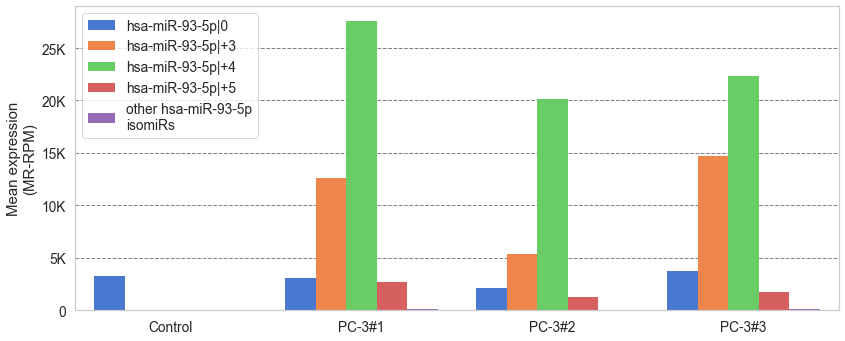

In [71]:
means_list = []

for c in CONSTRUCTS:
    samples_num = 3 if c == "PC-3#1" else 2
    expressions = 2**mirna_log_expressions_5prime[c] - 1
    
    overexp_mean = expressions.iloc[:, :samples_num].mean(axis=1)
    control_mean = expressions.iloc[:, samples_num:].mean(axis=1)
    
    if not means_list:
        means_list.append(control_mean)
    means_list.append(overexp_mean)
combined_means = pd.concat(means_list, keys=["Control", *CONSTRUCTS])
mean_expressions = pd.DataFrame({
    "isomir": combined_means.index.get_level_values(1),
    "Mean MR-RPM": combined_means.values, 
    "group": combined_means.index.get_level_values(0)
})
grouped_total_expr = mean_expressions.groupby("group")["Mean MR-RPM"].transform("sum")
mean_expressions["Mean MR-RPM Percentages"] = mean_expressions["Mean MR-RPM"] / grouped_total_expr * 100
isomirs_mask = mean_expressions.isomir.str.startswith(MIR_NAME)

df = mean_expressions[isomirs_mask].sort_values(["Mean MR-RPM", "group"], ascending=[False, True])
grouped_total_fracs = df.groupby("group")["Mean MR-RPM"].transform("sum")
df["Normalized Mean MR-RPM Percentages"] = df["Mean MR-RPM"] / grouped_total_fracs * 100
df.loc[df.isomir.str.endswith(("-2", "-1", "+1", "+2", "+6")), "isomir"] = "other"

df.isomir = (
    df.isomir
    .str.replace("other", f"other {MIR_NAME}\nisomiRs")
)


plt.figure(figsize=(12, 5))

ax = sns.barplot(x="group", y="Mean MR-RPM", data=df, 
                 hue="isomir", order=["Control", *CONSTRUCTS], 
                 hue_order=[
                     f"{MIR_NAME}|0",
                     f"{MIR_NAME}|+3",
                     f"{MIR_NAME}|+4",
                     f"{MIR_NAME}|+5",
                     f"other {MIR_NAME}\nisomiRs"
                 ],
                 linewidth=0, saturation=1, errorbar=None)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}K" if x > 0 else int(x)))
ax.set_ylabel("Mean expression\n(MR-RPM)")

plt.legend(title=None, loc="upper left")
plt.xlabel(None)

plt.tight_layout()

plt.savefig(FIGURES_DIR / Path("mean_expression_isomiRs_reorder.png"), dpi=350)
plt.savefig(FIGURES_DIR / Path("mean_expression_isomiRs_reorder.tiff"), dpi=1200)

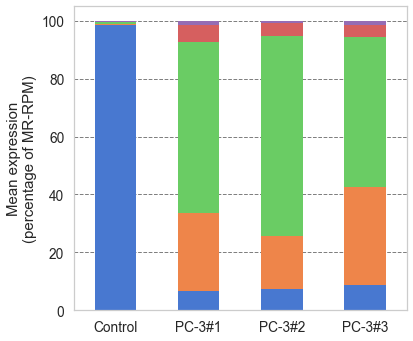

In [72]:
means_list = []

for c in CONSTRUCTS:
    samples_num = 3 if c == "PC-3#1" else 2
    expressions = 2**mirna_log_expressions_5prime[c] - 1
    
    overexp_mean = expressions.iloc[:, :samples_num].mean(axis=1)
    control_mean = expressions.iloc[:, samples_num:].mean(axis=1)
    
    if not means_list:
        means_list.append(control_mean)
    means_list.append(overexp_mean)
    
mean_exprs = pd.concat(means_list, axis=1, keys=["Control", *CONSTRUCTS])
mean_exprs.index.name = "isomir"
isomirs_mask = mean_exprs.index.str.startswith(MIR_NAME)
isomirs_mean_exprs = mean_exprs[isomirs_mask]

isomirs_mean_fracs = isomirs_mean_exprs / isomirs_mean_exprs.sum() * 100

isomirs_mean_fracs = (
    isomirs_mean_fracs
    .rename(index=lambda name: name if name.endswith(("0", "+3", "+4", "+5")) else "other")
    .groupby("isomir")
    .sum()
)

isomirs_mean_fracs.index = (
    isomirs_mean_fracs.index
    .str.replace("other", f"other {MIR_NAME}\nisomiRs")
)

isomirs_mean_fracs = isomirs_mean_fracs.loc[[
    f"{MIR_NAME}|0",
    f"{MIR_NAME}|+3",
    f"{MIR_NAME}|+4",
    f"{MIR_NAME}|+5",
    f"other {MIR_NAME}\nisomiRs"
]]


ax = isomirs_mean_fracs.T.plot.bar(
    stacked=True, figsize=(6, 5), linewidth=0,
    color=sns.color_palette("muted")
)
ax
ax.tick_params(labelrotation=0)
ax.grid(axis="x")
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.set_ylabel("Mean expression\n(percentage of MR-RPM)")
ax.get_legend().remove()

plt.tight_layout()

plt.savefig(FIGURES_DIR / Path("mean_expression_isomiRs_percentages_reorder.png"), dpi=350)
plt.savefig(FIGURES_DIR / Path("mean_expression_isomiRs_percentages_reorder.tiff"), dpi=1200)

# GYM motif possibility calculation

In [73]:
gym_possible = set()
gym_impossible = set()

mirnas = pd.read_table(MIRBASE_FILE, index_col="miRNA")
for i, row in mirnas.iterrows():
    seq = row["Sequence"][row["Local start"]-1 : row["Local end"]]
    if seq[0] in {"U", "C"} and seq[1] in {"C", "A"}:
        gym_possible.add(row.name)
    else:
        gym_impossible.add(row.name)

In [74]:
len(gym_possible) / (len(gym_possible) + len(gym_impossible))

0.2816265060240964